In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Documents/agh/stopien_2/Project-MIDAS`


In [2]:
using MLJ, DataFrames, DataFramesMeta, CairoMakie, UnROOT, LaTeXStrings, MathTeXEngine, MLJBase
import StatsBase
CairoMakie.activate!()

## Introduction

The __goal__ of this project is to measure the mean lifetime of two particles: $\tau(\varXi_c^{\,+})$ and $\tau(\varXi_b^{\,0})$; and their difference $\varDelta\tau = \tau(\varXi_b^{\,0}) - \tau(\varXi_c^{\,+})$.

The way to do that is to fit an exponential function
$$ f(t)\approx e^{-\frac{t}{\tau}} $$
to the lifetime histograms.

Before we can do a reasonable fit we have to first prepare our data. To this end we want to train a ML classifier model that predicts whether a reconstructed candidate is compatible with the signal decay or background. This is similar to what we did last semester during one of the two Introduction to experimental high energy physics projects (the ATLAS project), where we applied rectangular cuts on our data to isolate the signal process. In this project we let a ML model do cuts or discern patterns in the data for us, because we want to isolate the
$$ \varXi_b^{\,0} \rightarrow \varXi_c^{\,+}\pi^- $$
process in our data. We use a second dataset for that, one that was generated in a Monte Carlo simulation, as signal data. We treat experimental data, where the mass of the $\varXi_c^{\,+}$ particle:
$$ M(\varXi_c^{\,+})<2450\,\text{MeV} \quad\vee\quad M(\varXi_c^{\,+})>2490\,\text{MeV} $$
as background (in the mass histograms coming from the experiment data we can see that their shape is rather flat).

## Data

#### simple function for plotting histograms

In [3]:
## uncomment below if the other theme breaks
# set_theme!(merge(theme_dark(), theme_latexfonts()) )

## comment this theme if something breaks
set_texfont_family!(FontFamily("TeXGyrePagella"))
set_theme!(Theme(
    fonts = (; regular = "TeX Gyre Pagella", bold = "TeX Gyre Pagella Bold"),
    fontsize = 11,
))

In [4]:
function plot_hist(data; title, xlabel="", bins=80, size=(600,400), yscale = identity)
    f = Figure(;size)

    ax = Axis(
        f[1, 1],
        title = title,
        xlabel = xlabel,
        ylabel = "Entries [-]",
        yscale = yscale
    )

    hist!(
        data,
        bins = 80,
        color = :yellow,
        strokecolor = :black,
        strokewidth = 1
    )

    f
end

function plot_hist(data, filename::AbstractString; title, xlabel="", bins=80, size=(600,400), yscale = identity)
    endswith(filename, r"\.\w+$") || (filename *= ".pdf")

    f = Figure(;size)

    ax = Axis(
        f[1, 1],
        title = title,
        xlabel = xlabel,
        ylabel = "Entries [-]",
        yscale = yscale
    )

    hist!(
        data,
        bins = 80,
        color = :yellow,
        strokecolor = :black,
        strokewidth = 1
    )

    save(filename, f)

    f
end

plot_hist (generic function with 2 methods)

### features selection

#### read `.root` files

In [5]:
f_exp = ROOTFile("data/Data_2018_Xib2XicPi_2018_MD.addVar.wMVA.root")

ROOTFile with 2 entries and 21 streamers.
data/Data_2018_Xib2XicPi_2018_MD.addVar.wMVA.root
└─ mytree (TTree)
   ├─ "Xb_ENDVERTEX_X"
   ├─ "Xb_ENDVERTEX_Y"
   ├─ "Xb_ENDVERTEX_Z"
   ├─ "⋮"
   ├─ "pi_PTo"
   ├─ "pi_Po"
   └─ "BDTG_Xib"


In [6]:
f_sim = ROOTFile("data/Sim_2018_Xib2XicPi_2018MC_MD.pid.addVar.wMVA.root")

ROOTFile with 2 entries and 21 streamers.
data/Sim_2018_Xib2XicPi_2018MC_MD.pid.addVar.wMVA.root
└─ mytree (TTree)
   ├─ "Xb_ENDVERTEX_X"
   ├─ "Xb_ENDVERTEX_Y"
   ├─ "Xb_ENDVERTEX_Z"
   ├─ "⋮"
   ├─ "wTisTos"
   ├─ "wLife"
   └─ "BDTG_Xib"


#### get variable names

In [7]:
vars_exp = LazyTree(f_exp, "mytree") |> names
println(vars_exp)
print(vars_exp |> length)

["Xc_FDCHI2_ORIVX", "PI_TRACK_Likelihood", "k_ORIVX_Y", "Xb_OWNPV_ZERR", "pi_PT", "p_OWNPV_Z", "k_ProbNNghost", "p_OWNPV_COV_", "pi_IP_OWNPV", "k_ORIVX_ZERR", "Xb_PE", "Xb_DTF_nIter", "PI_ProbNNghost", "Xc_PX", "pi_OWNPV_NDOF", "pi_TRACK_GhostProb", "p_PIDmu", "p_RichAboveKaThres", "pi_UsedRich1Gas", "p_TRACK_CloneDist", "PI_OWNPV_Z", "Xc_PT", "p_PX", "p_ETA", "PI_hasMuon", "Xb_Hlt2Topo2BodyDecision_Dec", "p_OWNPV_NDOF", "p_IPCHI2_OWNPVo", "PI_OWNPV_COV_", "Xb_PT", "Xb_Hlt2Global_TOS", "PI_OWNPV_YERR", "PI_P", "PI_PIDe", "pi_ProbNNghost", "OdinTCK", "alpha_p_k", "k_RichAbovePrThres", "p_RichAboveElThres", "p_ProbNNghost", "PI_PE", "p_ProbNNmu", "Xb_ENDVERTEX_Z", "Xb_DTF_Xi_cplus_decayLength", "Xb_DTF_PV_Y", "totCandidates", "Xc_ENDVERTEX_Y", "Xb_ENDVERTEX_COV_", "p_IP_OWNPV", "Xb_M", "Xb_ID", "Xb_Hlt2Phys_Dec", "Xc_FDCHI2_OWNPV", "k_OWNPV_ZERR", "Xb_Hlt2Global_Dec", "Xb_Hlt2TrackMVADecision_TIS", "k_isMuon", "pi_ETA", "HLT2TCK", "Xb_OWNPV_Y", "Xb_OWNPV_CHI2", "Xc_M", "p_ORIVX_COV_", "X

In [8]:
vars_sim = LazyTree(f_sim, "mytree") |> names
println(vars_sim)
print(vars_sim |> length)

["Xc_FDCHI2_ORIVX", "PI_TRACK_Likelihood", "Xc_MC_GD_GD_MOTHER_ID", "k_TRUEP_E", "p_TRUEID", "p_MC_MOTHER_ID", "k_ORIVX_Y", "Xb_OWNPV_ZERR", "pi_PT", "p_OWNPV_Z", "p_OWNPV_COV_", "pi_IP_OWNPV", "k_ORIVX_ZERR", "Xb_PE", "Xb_DTF_nIter", "Xc_PX", "pi_OWNPV_NDOF", "pi_TRACK_GhostProb", "k_TRUEENDVERTEX_Y", "p_TRACK_CloneDist", "p_ETA", "PI_OWNPV_Z", "Xc_PT", "p_PX", "Xb_Hlt2Topo2BodyDecision_Dec", "p_OWNPV_NDOF", "PI_TRUEENDVERTEX_Y", "p_IPCHI2_OWNPVo", "PI_OWNPV_COV_", "Xb_PT", "Xb_Hlt2Global_TOS", "k_TRUEORIGINVERTEX_Z", "PI_OWNPV_YERR", "PI_P", "OdinTCK", "wTisTos", "k_MC_GD_MOTHER_ID", "k_TRUEENDVERTEX_X", "alpha_p_k", "PI_PE", "Xb_ENDVERTEX_Z", "Xb_DTF_Xi_cplus_decayLength", "Xb_DTF_PV_Y", "k_MC_GD_GD_MOTHER_ID", "totCandidates", "Xb_TRUEORIGINVERTEX_Y", "Xc_ENDVERTEX_Y", "Xb_ENDVERTEX_COV_", "Xc_TRUEISSTABLE", "p_IP_OWNPV", "Xb_M", "Xb_Hlt2Phys_Dec", "Xc_FDCHI2_OWNPV", "k_OWNPV_ZERR", "Xb_Hlt2Global_Dec", "Xb_Hlt2TrackMVADecision_TIS", "pi_ETA", "HLT2TCK", "Xb_OWNPV_Y", "Xb_OWNPV_CHI

In [9]:
vars_common = intersect(vars_sim, vars_exp)
println(vars_common)
print(vars_common |> length)

["Xc_FDCHI2_ORIVX", "PI_TRACK_Likelihood", "k_ORIVX_Y", "Xb_OWNPV_ZERR", "pi_PT", "p_OWNPV_Z", "p_OWNPV_COV_", "pi_IP_OWNPV", "k_ORIVX_ZERR", "Xb_PE", "Xb_DTF_nIter", "Xc_PX", "pi_OWNPV_NDOF", "pi_TRACK_GhostProb", "p_TRACK_CloneDist", "p_ETA", "PI_OWNPV_Z", "Xc_PT", "p_PX", "Xb_Hlt2Topo2BodyDecision_Dec", "p_OWNPV_NDOF", "p_IPCHI2_OWNPVo", "PI_OWNPV_COV_", "Xb_PT", "Xb_Hlt2Global_TOS", "PI_OWNPV_YERR", "PI_P", "OdinTCK", "alpha_p_k", "PI_PE", "Xb_ENDVERTEX_Z", "Xb_DTF_Xi_cplus_decayLength", "Xb_DTF_PV_Y", "totCandidates", "Xc_ENDVERTEX_Y", "Xb_ENDVERTEX_COV_", "p_IP_OWNPV", "Xb_M", "Xb_Hlt2Phys_Dec", "Xc_FDCHI2_OWNPV", "k_OWNPV_ZERR", "Xb_Hlt2Global_Dec", "Xb_Hlt2TrackMVADecision_TIS", "pi_ETA", "HLT2TCK", "Xb_OWNPV_Y", "Xb_OWNPV_CHI2", "Xc_M", "p_ORIVX_COV_", "Xb_Hlt2Phys_TOS", "p_TRACK_Likelihood", "nVeloClusters", "nDownstreamTracks", "nTTClusters", "nCandidate", "eventNumber", "pi_TRACK_CHI2NDOF", "Xc_OWNPV_NDOF", "Xc_DIRA_OWNPV", "PI_PX", "pi_ORIVX_ZERR", "k_ProbNNk", "Xb_Hlt2Tra

#### filter through common variables

Looking for features similar to the ones in previous semester's Standard Model project.

In [10]:
filter(var -> startswith(var, "Xb_"), vars_common) |> print

["Xb_OWNPV_ZERR", "Xb_PE", "Xb_DTF_nIter", "Xb_Hlt2Topo2BodyDecision_Dec", "Xb_PT", "Xb_Hlt2Global_TOS", "Xb_ENDVERTEX_Z", "Xb_DTF_Xi_cplus_decayLength", "Xb_DTF_PV_Y", "Xb_ENDVERTEX_COV_", "Xb_M", "Xb_Hlt2Phys_Dec", "Xb_Hlt2Global_Dec", "Xb_Hlt2TrackMVADecision_TIS", "Xb_OWNPV_Y", "Xb_OWNPV_CHI2", "Xb_Hlt2Phys_TOS", "Xb_Hlt2TrackMVADecision_Dec", "Xb_IP_OWNPV", "Xb_ENDVERTEX_XERR", "Xb_Hlt2Topo3BodyDecision_TIS", "Xb_L0Global_TOS", "Xb_DTF_Xi_cplus_ctau", "Xb_L0Global_Dec", "Xb_OWNPV_YERR", "Xb_DTF_PV_key", "Xb_DTF_PERR", "Xb_DTF_nPV", "Xb_L0HadronDecision_TOS", "Xb_FD_OWNPV", "Xb_ENDVERTEX_X", "Xb_Hlt2Global_TIS", "Xb_Hlt1TrackMVADecision_TIS", "Xb_TAU", "Xb_DTF_Xi_cplus_ctauErr", "Xb_Hlt2Topo2BodyDecision_TIS", "Xb_Hlt1Phys_TOS", "Xb_L0HadronDecision_Dec", "Xb_TAUCHI2", "Xb_ENDVERTEX_NDOF", "Xb_ETA", "Xb_PY", "Xb_IPCHI2_OWNPV", "Xb_Hlt1Phys_Dec", "Xb_ENDVERTEX_CHI2", "Xb_MM", "Xb_L0MuonDecision_TIS", "Xb_L0HadronDecision_TIS", "Xb_DTF_Xi_cplus_MERR", "Xb_DTF_Xi_cplus_P", "Xb_DTF_MER

In [11]:
filter(var -> startswith(var, "Xc_"), vars_common) |> print

["Xc_FDCHI2_ORIVX", "Xc_PX", "Xc_PT", "Xc_ENDVERTEX_Y", "Xc_FDCHI2_OWNPV", "Xc_M", "Xc_OWNPV_NDOF", "Xc_DIRA_OWNPV", "Xc_ORIVX_COV_", "Xc_PY", "Xc_IP_OWNPV", "Xc_ENDVERTEX_YERR", "Xc_ORIVX_Z", "Xc_DIRA_ORIVX", "Xc_ORIVX_XERR", "Xc_PE", "Xc_TAUERR", "Xc_OWNPV_CHI2", "Xc_OWNPV_Y", "Xc_PZ", "Xc_ENDVERTEX_NDOF", "Xc_IPCHI2_OWNPV", "Xc_OWNPV_YERR", "Xc_ORIVX_NDOF", "Xc_FD_ORIVX", "Xc_MMERR", "Xc_ENDVERTEX_COV_", "Xc_ENDVERTEX_XERR", "Xc_ORIVX_CHI2", "Xc_ORIVX_Y", "Xc_OWNPV_ZERR", "Xc_P", "Xc_OWNPV_COV_", "Xc_TAUCHI2", "Xc_ORIVX_X", "Xc_ENDVERTEX_X", "Xc_MM", "Xc_OWNPV_XERR", "Xc_FDCHI2_OWNPVo", "Xc_TAU", "Xc_FD_OWNPV", "Xc_ENDVERTEX_CHI2", "Xc_ORIVX_ZERR", "Xc_ORIVX_YERR", "Xc_ENDVERTEX_Z", "Xc_OWNPV_Z", "Xc_OWNPV_X", "Xc_ENDVERTEX_ZERR"]

In [12]:
filter(var -> startswith(var, "pi_"), vars_common) |> print

["pi_PT", "pi_IP_OWNPV", "pi_OWNPV_NDOF", "pi_TRACK_GhostProb", "pi_ETA", "pi_TRACK_CHI2NDOF", "pi_ORIVX_ZERR", "pi_PX", "pi_OWNPV_Y", "pi_PZ", "pi_PY", "pi_ProbNNpi", "pi_ORIVX_NDOF", "pi_ORIVX_Z", "pi_TRACK_CloneDist", "pi_Po", "pi_ORIVX_Y", "pi_OWNPV_COV_", "pi_P", "pi_TRACK_Key", "pi_OWNPV_ZERR", "pi_ORIVX_XERR", "pi_OWNPV_Z", "pi_TRACK_PCHI2", "pi_OWNPV_YERR", "pi_ORIVX_X", "pi_ORIVX_YERR", "pi_IPCHI2_OWNPVo", "pi_IPCHI2_OWNPV", "pi_OWNPV_CHI2", "pi_PE", "pi_OWNPV_XERR", "pi_ORIVX_COV_", "pi_TRACK_Type", "pi_M", "pi_ORIVX_CHI2", "pi_TRACK_Likelihood", "pi_TRACK_MatchCHI2", "pi_PTo", "pi_OWNPV_X"]

In [13]:
filter(var -> occursin("ProbNN", var), vars_common) |> print

["k_ProbNNk", "pi_ProbNNpi", "PI_ProbNNpi", "p_ProbNNp"]

In [14]:
filter(var -> occursin("CHI2", var), vars_common) |> print

["Xc_FDCHI2_ORIVX", "p_IPCHI2_OWNPVo", "Xc_FDCHI2_OWNPV", "Xb_OWNPV_CHI2", "pi_TRACK_CHI2NDOF", "p_IPCHI2_OWNPV", "k_TRACK_MatchCHI2", "PI_OWNPV_CHI2", "Xc_OWNPV_CHI2", "PI_TRACK_MatchCHI2", "PI_ORIVX_CHI2", "p_TRACK_CHI2NDOF", "p_OWNPV_CHI2", "Xc_IPCHI2_OWNPV", "Xb_TAUCHI2", "Xb_IPCHI2_OWNPV", "k_TRACK_CHI2NDOF", "Xb_ENDVERTEX_CHI2", "p_TRACK_MatchCHI2", "k_OWNPV_CHI2", "k_ORIVX_CHI2", "pi_TRACK_PCHI2", "p_ORIVX_CHI2", "Xc_ORIVX_CHI2", "PI_TRACK_PCHI2", "PI_TRACK_CHI2NDOF", "k_TRACK_PCHI2", "Xb_FDCHI2_OWNPVo", "k_IPCHI2_OWNPV", "Xc_TAUCHI2", "pi_IPCHI2_OWNPVo", "pi_IPCHI2_OWNPV", "pi_OWNPV_CHI2", "PI_IPCHI2_OWNPV", "k_IPCHI2_OWNPVo", "Xc_FDCHI2_OWNPVo", "PI_IPCHI2_OWNPVo", "Xc_ENDVERTEX_CHI2", "p_TRACK_PCHI2", "pi_ORIVX_CHI2", "pi_TRACK_MatchCHI2", "Xb_ENDVERTEX_CHI2o", "Xb_FDCHI2_OWNPV"]

In [15]:
filter(var -> occursin("NDOF", var), vars_common) |> print

["pi_OWNPV_NDOF", "p_OWNPV_NDOF", "pi_TRACK_CHI2NDOF", "Xc_OWNPV_NDOF", "pi_ORIVX_NDOF", "Xc_ENDVERTEX_NDOF", "p_TRACK_CHI2NDOF", "Xb_ENDVERTEX_NDOF", "k_TRACK_CHI2NDOF", "Xc_ORIVX_NDOF", "k_ORIVX_NDOF", "PI_TRACK_CHI2NDOF", "k_OWNPV_NDOF", "p_ORIVX_NDOF", "PI_OWNPV_NDOF", "Xb_OWNPV_NDOF", "PI_ORIVX_NDOF"]

In [16]:
filter(var -> occursin("TRACK", var), vars_common) |> print

["PI_TRACK_Likelihood", "pi_TRACK_GhostProb", "p_TRACK_CloneDist", "p_TRACK_Likelihood", "pi_TRACK_CHI2NDOF", "PI_TRACK_CloneDist", "k_TRACK_MatchCHI2", "pi_TRACK_CloneDist", "PI_TRACK_MatchCHI2", "pi_TRACK_Key", "k_TRACK_Likelihood", "p_TRACK_CHI2NDOF", "p_TRACK_GhostProb", "k_TRACK_CHI2NDOF", "p_TRACK_MatchCHI2", "pi_TRACK_PCHI2", "PI_TRACK_PCHI2", "PI_TRACK_Key", "PI_TRACK_CHI2NDOF", "k_TRACK_PCHI2", "k_TRACK_Key", "k_TRACK_GhostProb", "p_TRACK_Type", "k_TRACK_CloneDist", "p_TRACK_PCHI2", "pi_TRACK_Type", "p_TRACK_Key", "pi_TRACK_Likelihood", "pi_TRACK_MatchCHI2", "PI_TRACK_GhostProb", "PI_TRACK_Type", "k_TRACK_Type"]

In [17]:
filter(var -> occursin("PT", var), vars_common) |> print

["pi_PT", "Xc_PT", "Xb_PT", "p_PT", "k_PT", "PI_PT", "pi_PTo"]

#### Final features selection

* `DIRA` -- direction angle,
* `IP` -- impact parameter,
* `FD` -- flight distance,
* ...

In [18]:
features = [
    "Xb_DIRA_OWNPV",
    "Xb_IPCHI2_OWNPV",
    "Xb_FDCHI2_OWNPV",
    "Xb_ENDVERTEX_CHI2",
    "Xb_PT",
    "Xc_DIRA_OWNPV",
    "Xc_IPCHI2_OWNPV",
    "Xc_FDCHI2_OWNPV",
    "Xc_ENDVERTEX_CHI2",
    "Xc_PT",
    "p_TRACK_CHI2NDOF",
    "p_TRACK_GhostProb",
    "p_ProbNNp",
    "p_PT",
    "k_TRACK_CHI2NDOF",
    "k_TRACK_GhostProb",
    "k_PT",
    "k_ProbNNk",
    "pi_TRACK_CHI2NDOF",
    "pi_TRACK_GhostProb",
    "pi_PT",
    "pi_ProbNNpi",
];

### experiment data

In [19]:
df_exp = LazyTree(f_exp, "mytree", vcat(["Xb_M", "Xc_M", "Xb_TAU", "Xc_TAU"], features)) |> DataFrame

Row,p_TRACK_CHI2NDOF,Xc_TAU,Xb_TAU,pi_PT,Xb_IPCHI2_OWNPV,p_TRACK_GhostProb,k_TRACK_CHI2NDOF,Xb_DIRA_OWNPV,pi_TRACK_CHI2NDOF,Xb_ENDVERTEX_CHI2,Xc_DIRA_OWNPV,pi_TRACK_GhostProb,Xb_M,Xc_IPCHI2_OWNPV,Xc_FDCHI2_OWNPV,k_PT,Xc_PT,k_ProbNNk,Xc_M,Xb_PT,p_ProbNNp,k_TRACK_GhostProb,Xb_FDCHI2_OWNPV,Xc_ENDVERTEX_CHI2,pi_ProbNNpi,p_PT
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.916201,0.000815827,0.00167324,128.175,50.0878,0.00951012,0.893705,0.999913,2.11694,0.047918,0.999984,0.313751,5906.68,127.808,1511.59,3332.74,7477.31,0.228634,2510.3,6894.96,0.216751,0.0033191,507.372,1.76876,0.0543855,4053.7
2,0.673245,0.00138945,0.0026473,4475.73,5.41138,0.00294041,0.759904,0.999998,1.93229,0.274207,0.999545,0.0447053,5679.12,1802.61,8142.38,1438.16,8059.38,0.935612,2468.57,12263.8,0.366651,0.00341138,11738.4,14.9461,0.790995,1640.81
3,1.51315,-0.000351875,0.000806715,678.489,20.0116,0.00531317,0.935301,0.999964,1.13082,3.81626,0.994573,0.00415959,5690.74,58.1446,65.4925,1797.68,2690.1,0.997921,2517.45,9822.61,0.37178,0.00375488,419.79,1.69332,0.997966,443.215
4,1.23012,0.000624979,0.000491548,262.852,11.8004,0.0025048,1.08445,0.999913,2.07114,4.76857,0.999988,0.158746,5945.17,29.8475,413.465,3894.14,6788.47,0.460054,2428.47,6867.44,0.200149,0.00232569,51.807,1.48557,0.21611,2739.07
5,0.844429,0.00113982,0.00240525,161.211,11.8522,0.0180421,0.981377,0.999989,0.997703,2.68415,0.999291,0.0246846,5646.24,350.99,415.566,1302.94,1823.01,0.924755,2484.98,7531.45,0.719652,0.00451679,2576.45,1.35653,0.954604,408.723
6,1.76191,1.11562e-6,0.00129938,772.127,8.52095,0.00456974,0.668473,0.999991,0.768105,2.82344,0.999355,0.00536665,5561.59,98.7232,446.497,463.949,1606.59,0.948623,2444.5,5357.65,0.899079,0.00441898,261.553,0.141041,0.984076,643.541
7,1.59362,0.000933746,0.00228823,1255.15,86.5175,0.318535,1.35356,0.999951,0.697048,2.53569,0.999646,0.00300516,5596.13,394.034,1343.27,368.392,2291.52,0.144492,2439.99,2990.9,0.388912,0.00539023,1459.21,17.6746,0.969696,778.657
8,1.13069,0.00241897,0.00160916,661.248,15.7621,0.00430404,0.499573,0.999963,1.48535,0.689831,0.999935,0.0297656,6031.52,88.2765,374.476,1097.2,2138.7,0.239343,2491.02,2743.43,0.880779,0.0028453,1012.79,3.18664,0.990926,478.557
9,1.57668,-2.46276e-5,0.00108872,1165.43,1.95124,0.0228336,1.08719,0.999978,0.698005,5.11059,0.99668,0.0036398,5647.72,160.145,500.712,3416.34,7946.66,0.998203,2462.74,11692.0,0.42274,0.00352195,777.882,1.6963,0.997828,3298.79


#### plots (pre initial cut)

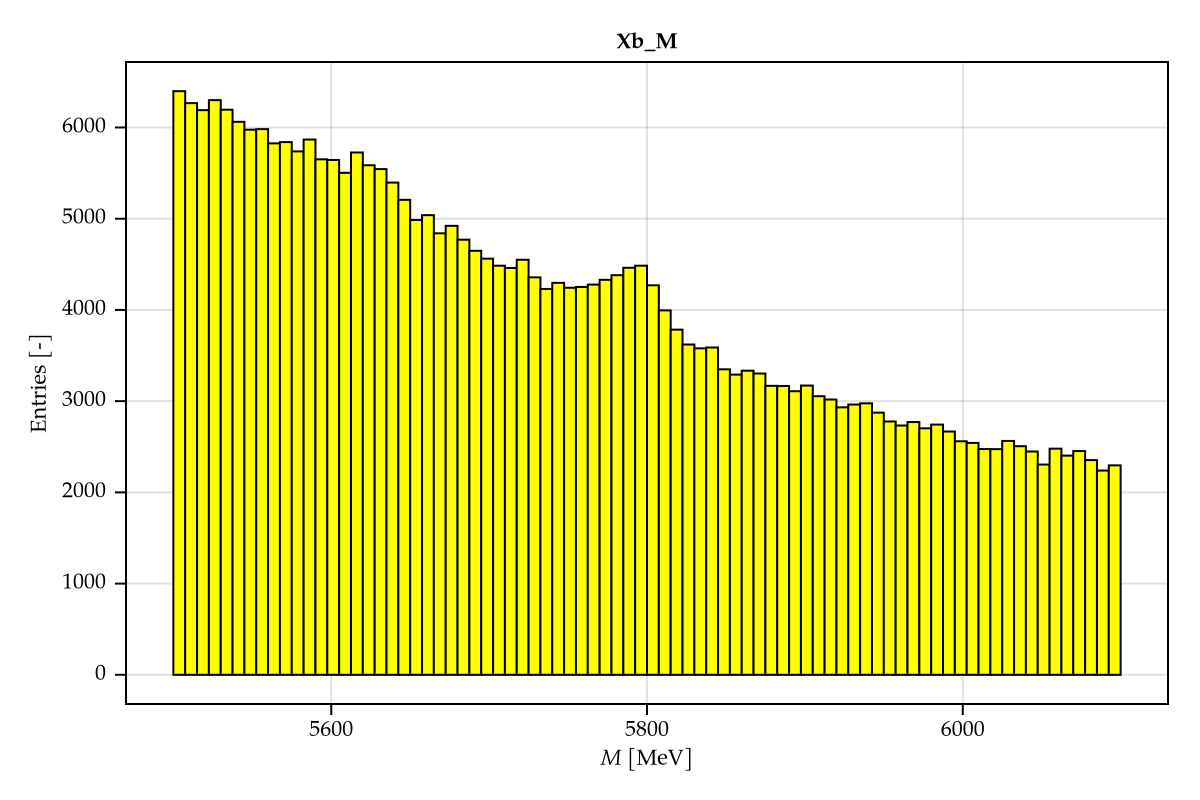

In [20]:
plot_hist(
    df_exp.Xb_M,
    # "figures/exp_Xb_M",
    title = "Xb_M",
    xlabel = L"$M$ [MeV]"
)

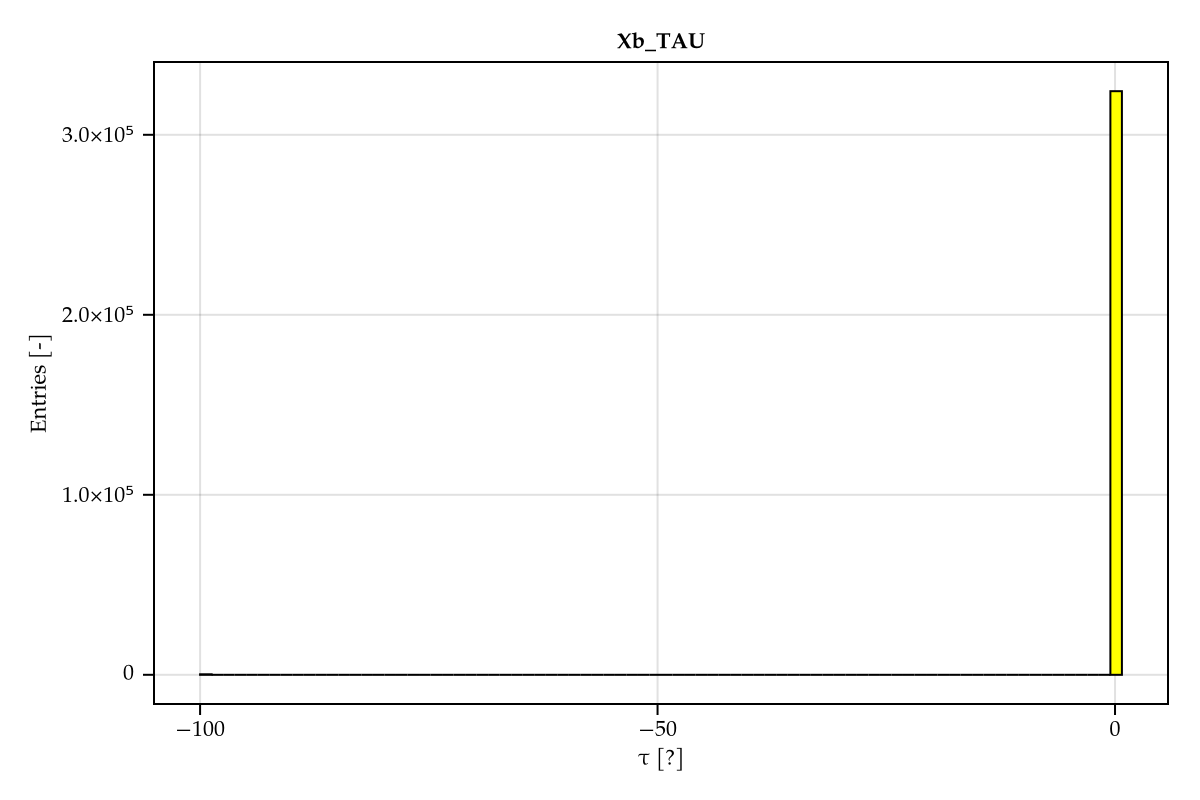

In [21]:
plot_hist(
    df_exp.Xb_TAU,
    title = "Xb_TAU",
    xlabel = L"$\tau$ [?]"
)

In [22]:
minimum(df_exp.Xb_TAU)

-100.0

I suppose that this one bin behaviour is caused by there being values of -100 in the data. From a physics standpoint $\tau$ cannot take on a negative value. I suppose that some values below 0 could be caused by measurement uncertainties, but -100 is almost definitely a value assigned when something wrong happened in the measurement.

In [23]:
@subset df_exp :Xb_TAU .< -1

Row,p_TRACK_CHI2NDOF,Xc_TAU,Xb_TAU,pi_PT,Xb_IPCHI2_OWNPV,p_TRACK_GhostProb,k_TRACK_CHI2NDOF,Xb_DIRA_OWNPV,pi_TRACK_CHI2NDOF,Xb_ENDVERTEX_CHI2,Xc_DIRA_OWNPV,pi_TRACK_GhostProb,Xb_M,Xc_IPCHI2_OWNPV,Xc_FDCHI2_OWNPV,k_PT,Xc_PT,k_ProbNNk,Xc_M,Xb_PT,p_ProbNNp,k_TRACK_GhostProb,Xb_FDCHI2_OWNPV,Xc_ENDVERTEX_CHI2,pi_ProbNNpi,p_PT
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.93867,0.000141408,-100.0,283.666,4697.95,0.044362,0.727541,0.999985,1.97606,2.6055,0.999994,0.307954,5732.37,1513.01,5535.11,549.117,7238.41,0.357772,2485.85,8579.89,0.319314,0.00720093,1.49852e6,0.146121,0.437417,6449.09
2,2.85811,-1.67852e-5,-100.0,734.041,3479.78,0.344243,0.929193,0.99999,1.51394,1.40137,0.999647,0.0681798,6004.97,44902.0,1.13724e6,830.278,2145.17,0.787413,2473.72,11185.3,0.307625,0.0034035,6.32534e5,1.04734,0.460989,704.686
3,2.01563,9.35565e-5,-100.0,813.339,26191.9,0.139611,0.909742,0.999907,1.33541,4.88787,0.999744,0.0310706,6012.56,24244.7,3.66595e5,1186.42,2825.95,0.483654,2477.59,11984.0,0.525422,0.0035605,1.9155e5,3.37556,0.849047,998.861
4,2.7243,9.95654e-5,-100.0,813.339,26458.1,0.144915,0.909742,0.999906,1.33541,4.86385,0.999742,0.0310706,5983.83,24779.1,3.72095e5,1186.42,2860.16,0.483654,2466.84,12017.5,0.276528,0.0035605,1.93834e5,3.46047,0.849047,1033.41
5,1.113,3.31048e-5,-100.0,383.413,18060.2,0.0135307,1.54229,0.999971,3.1415,6.7184,0.999535,0.0961362,5634.29,66332.0,8.952e6,1193.46,2709.38,0.373425,2450.06,7469.52,0.648417,0.0526077,2.26022e6,3.9187,0.716482,1244.31
6,1.40579,0.000318319,-100.0,2989.13,340.891,0.0420975,1.12617,0.999987,0.825439,8.38334,0.99999,0.004175,5896.27,334.042,16543.8,9526.65,16602.6,0.12821,2446.98,87005.0,0.632769,0.0202761,1158.35,20.4483,0.227907,3760.24
7,1.19888,0.000673656,-100.0,511.715,2696.74,0.00217586,0.994888,0.999996,0.822026,0.00678291,0.999993,0.0289099,5938.25,3594.12,79780.7,2915.84,7086.27,0.212333,2435.34,40513.5,0.350565,0.00212551,8317.35,8.79564,0.983638,3836.08
8,2.76412,7.20228e-5,-100.0,680.341,492.534,0.255972,0.650863,0.999996,0.639827,0.646951,0.999774,0.0215039,5730.31,13950.3,1.47673e6,2391.97,3715.77,0.999032,2454.82,14507.3,0.206715,0.0036039,1.22611e5,3.75615,0.878542,567.101
9,1.11999,-0.00363508,-100.0,911.38,169.867,0.00620167,1.10119,0.999999,0.925872,6.04588,0.999995,0.00483481,6027.0,197.581,1.99669e5,496.597,2898.77,0.146571,2472.96,13792.6,0.9863,0.00485063,75248.0,2.6573,0.965816,1394.92


In [24]:
print("Number of entries with Xb_TAU value below -1:   $(sum(df_exp.Xb_TAU .< -1))
Number of entries with Xb_TAU equal to -100:    $(sum(df_exp.Xb_TAU .== -100))
Number of entries with Xb_TAU below 0:          $(sum(df_exp.Xb_TAU .< 0))\n
ergo: $(sum(df_exp.Xb_TAU .== -100)) weird Xb_TAU values, the $(sum(df_exp.Xb_TAU .< 0) - sum(df_exp.Xb_TAU .== -100)) values below 0 probably due to measurement uncertainty -- okayish
")

Number of entries with Xb_TAU value below -1:   292
Number of entries with Xb_TAU equal to -100:    292
Number of entries with Xb_TAU below 0:          299

ergo: 292 weird Xb_TAU values, the 7 values below 0 probably due to measurement uncertainty -- okayish


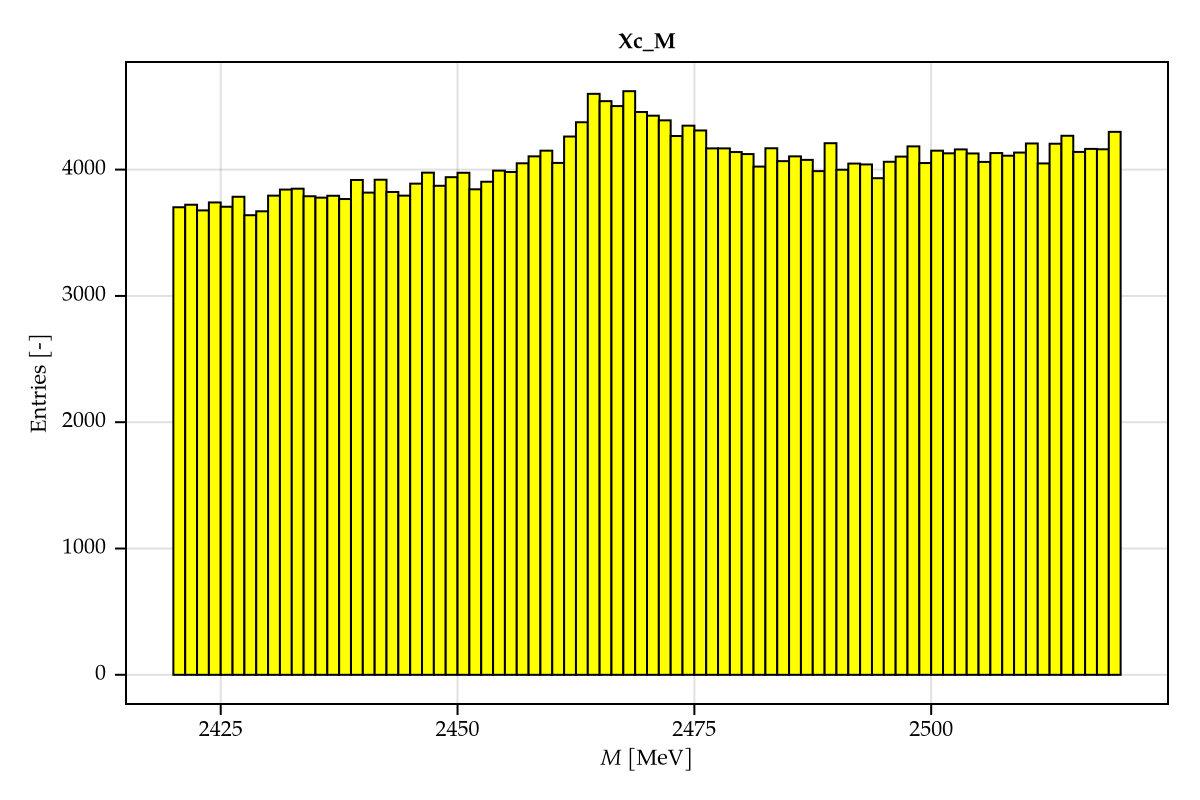

In [25]:
plot_hist(
    df_exp.Xc_M,
    "figures/exp_Xc_M",
    title = "Xc_M",
    xlabel = L"$M$ [MeV]"
)

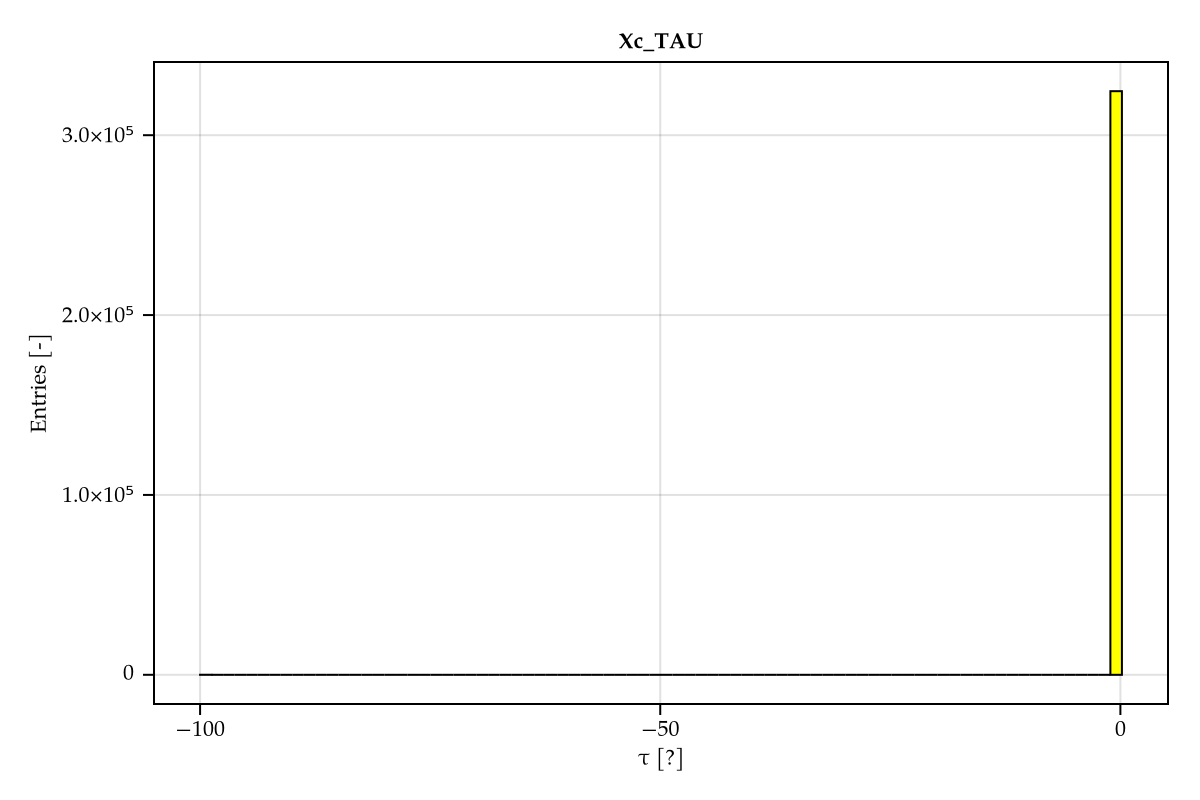

In [26]:
plot_hist(
    df_exp.Xc_TAU,
    title = "Xc_TAU",
    xlabel = L"$\tau$ [?]"
)

In [27]:
minimum(df_exp.Xc_TAU)

-100.0

same behaviour as in Xb_TAU

In [28]:
@subset df_exp :Xc_TAU .< -1

Row,p_TRACK_CHI2NDOF,Xc_TAU,Xb_TAU,pi_PT,Xb_IPCHI2_OWNPV,p_TRACK_GhostProb,k_TRACK_CHI2NDOF,Xb_DIRA_OWNPV,pi_TRACK_CHI2NDOF,Xb_ENDVERTEX_CHI2,Xc_DIRA_OWNPV,pi_TRACK_GhostProb,Xb_M,Xc_IPCHI2_OWNPV,Xc_FDCHI2_OWNPV,k_PT,Xc_PT,k_ProbNNk,Xc_M,Xb_PT,p_ProbNNp,k_TRACK_GhostProb,Xb_FDCHI2_OWNPV,Xc_ENDVERTEX_CHI2,pi_ProbNNpi,p_PT
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2.1126,-100.0,0.00344676,2047.13,329.037,0.0842025,1.47655,0.999936,2.42713,5.78749,1.0,0.144944,6042.8,335.73,585.046,3113.29,6384.94,0.262342,2500.38,7702.72,0.285184,0.0149242,62071.6,0.00377781,0.327619,988.947
2,1.10656,-100.0,0.0127124,1001.41,176.937,0.00848115,1.66552,1.0,1.77358,0.0428647,0.999999,0.0525537,5605.49,198.939,1.20943e5,199.607,5929.3,0.371852,2490.04,30226.9,0.640743,0.0236597,600.863,5.55769,0.829196,4641.79
3,1.18847,-100.0,0.00343243,1464.34,25.0291,0.0340591,1.89648,0.999998,3.06926,0.884048,0.999987,0.0910792,5653.08,74.2211,81.21,394.018,2487.74,0.641818,2518.13,10233.4,0.354512,0.0359521,469.756,0.000102383,0.252741,456.922
4,1.26855,-100.0,0.00135625,794.284,23.0255,0.00961125,2.01895,0.999921,1.58849,0.923932,1.0,0.370468,5675.85,72.8651,224.222,2752.9,4310.95,0.144899,2474.63,3790.57,0.252289,0.299517,990.14,0.00398534,0.0786642,673.253
5,3.16753,-100.0,0.0162359,1499.45,6.03217,0.192181,0.509539,1.0,0.696295,5.80013,0.999951,0.00366842,5575.96,1.87388,88.8944,370.671,4022.8,0.466097,2450.55,20810.8,0.635814,0.0356745,11.392,1.77796,0.0155884,2170.96
6,2.99939,-100.0,0.00477073,3147.42,130.496,0.163265,3.75859,0.999993,1.75543,0.674635,0.999982,0.0633962,5669.47,372.797,2669.82,1031.68,5518.86,0.146364,2512.05,29067.9,0.228307,0.237319,227.805,0.00860505,0.203022,973.301
7,1.88948,-100.0,0.00224793,1736.32,42.2122,0.394475,1.03629,0.999999,2.2415,5.94755,0.999997,0.151863,5668.97,2696.69,6191.33,4373.49,7499.01,0.189021,2460.85,26301.2,0.208467,0.0271529,2979.76,0.00118076,0.383909,1186.72
8,1.74301,-100.0,0.0126545,2257.9,1105.7,0.0996769,1.13598,0.999992,1.93913,3.39129,0.999991,0.100627,5623.3,788.504,840.283,7931.15,12393.1,0.275622,2468.96,13454.1,0.418271,0.00309682,6.74891e5,0.00263198,0.221786,1941.64
9,1.02794,-100.0,0.000802103,977.8,172.951,0.00816245,2.14222,0.999966,1.5196,1.37859,0.999997,0.353203,5566.41,404.346,3519.79,205.144,3960.51,0.408486,2466.95,12310.5,0.429495,0.249664,222.819,0.0027357,0.201845,2661.67


In [29]:
print("Number of entries with Xc_TAU value below -1:   $(sum(df_exp.Xc_TAU .< -1))
Number of entries with Xc_TAU equal to -100:    $(sum(df_exp.Xc_TAU .== -100))
Number of entries with Xc_TAU below 0:          $(sum(df_exp.Xc_TAU .< 0))\n
ergo: $(sum(df_exp.Xc_TAU .== -100)) weird Xc_TAU values, the $(sum(df_exp.Xc_TAU .< 0) - sum(df_exp.Xc_TAU .== -100)) values below 0 probably due to measurement uncertainty -- okayish
a lot more than with Xb_TAU, we even get a measurement below -1 that isn't registered as -100!

Xb_TAU == -100 and Xc_TAU == -100 overlap:
")
@subset df_exp :Xb_TAU .== -100 :Xc_TAU .== -100

Number of entries with Xc_TAU value below -1:   32
Number of entries with Xc_TAU equal to -100:    31
Number of entries with Xc_TAU below 0:          117842

ergo: 31 weird Xc_TAU values, the 117811 values below 0 probably due to measurement uncertainty -- okayish
a lot more than with Xb_TAU, we even get a measurement below -1 that isn't registered as -100!

Xb_TAU == -100 and Xc_TAU == -100 overlap:


Row,p_TRACK_CHI2NDOF,Xc_TAU,Xb_TAU,pi_PT,Xb_IPCHI2_OWNPV,p_TRACK_GhostProb,k_TRACK_CHI2NDOF,Xb_DIRA_OWNPV,pi_TRACK_CHI2NDOF,Xb_ENDVERTEX_CHI2,Xc_DIRA_OWNPV,pi_TRACK_GhostProb,Xb_M,Xc_IPCHI2_OWNPV,Xc_FDCHI2_OWNPV,k_PT,Xc_PT,k_ProbNNk,Xc_M,Xb_PT,p_ProbNNp,k_TRACK_GhostProb,Xb_FDCHI2_OWNPV,Xc_ENDVERTEX_CHI2,pi_ProbNNpi,p_PT
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2.68677,-100.0,-100.0,3083.1,111.829,0.202407,2.10364,1.0,2.27569,0.0322061,1.0,0.100394,5555.56,121.58,2104.81,401.223,7115.33,0.115885,2515.87,34758.3,0.402268,0.174242,1277.51,0.0227398,0.429116,3268.59


as we can see events in which both Xb_TAU and Xc_TAU are registered as -100 are rather _rare_

#### cut out weird values in the data

We want to cut out rows in which Xb_TAU or Xc_TAU takes on the value of -100:

In [30]:
df_exp_cut = @rsubset df_exp :Xb_TAU != -100 && :Xc_TAU != -100

Row,p_TRACK_CHI2NDOF,Xc_TAU,Xb_TAU,pi_PT,Xb_IPCHI2_OWNPV,p_TRACK_GhostProb,k_TRACK_CHI2NDOF,Xb_DIRA_OWNPV,pi_TRACK_CHI2NDOF,Xb_ENDVERTEX_CHI2,Xc_DIRA_OWNPV,pi_TRACK_GhostProb,Xb_M,Xc_IPCHI2_OWNPV,Xc_FDCHI2_OWNPV,k_PT,Xc_PT,k_ProbNNk,Xc_M,Xb_PT,p_ProbNNp,k_TRACK_GhostProb,Xb_FDCHI2_OWNPV,Xc_ENDVERTEX_CHI2,pi_ProbNNpi,p_PT
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.916201,0.000815827,0.00167324,128.175,50.0878,0.00951012,0.893705,0.999913,2.11694,0.047918,0.999984,0.313751,5906.68,127.808,1511.59,3332.74,7477.31,0.228634,2510.3,6894.96,0.216751,0.0033191,507.372,1.76876,0.0543855,4053.7
2,0.673245,0.00138945,0.0026473,4475.73,5.41138,0.00294041,0.759904,0.999998,1.93229,0.274207,0.999545,0.0447053,5679.12,1802.61,8142.38,1438.16,8059.38,0.935612,2468.57,12263.8,0.366651,0.00341138,11738.4,14.9461,0.790995,1640.81
3,1.51315,-0.000351875,0.000806715,678.489,20.0116,0.00531317,0.935301,0.999964,1.13082,3.81626,0.994573,0.00415959,5690.74,58.1446,65.4925,1797.68,2690.1,0.997921,2517.45,9822.61,0.37178,0.00375488,419.79,1.69332,0.997966,443.215
4,1.23012,0.000624979,0.000491548,262.852,11.8004,0.0025048,1.08445,0.999913,2.07114,4.76857,0.999988,0.158746,5945.17,29.8475,413.465,3894.14,6788.47,0.460054,2428.47,6867.44,0.200149,0.00232569,51.807,1.48557,0.21611,2739.07
5,0.844429,0.00113982,0.00240525,161.211,11.8522,0.0180421,0.981377,0.999989,0.997703,2.68415,0.999291,0.0246846,5646.24,350.99,415.566,1302.94,1823.01,0.924755,2484.98,7531.45,0.719652,0.00451679,2576.45,1.35653,0.954604,408.723
6,1.76191,1.11562e-6,0.00129938,772.127,8.52095,0.00456974,0.668473,0.999991,0.768105,2.82344,0.999355,0.00536665,5561.59,98.7232,446.497,463.949,1606.59,0.948623,2444.5,5357.65,0.899079,0.00441898,261.553,0.141041,0.984076,643.541
7,1.59362,0.000933746,0.00228823,1255.15,86.5175,0.318535,1.35356,0.999951,0.697048,2.53569,0.999646,0.00300516,5596.13,394.034,1343.27,368.392,2291.52,0.144492,2439.99,2990.9,0.388912,0.00539023,1459.21,17.6746,0.969696,778.657
8,1.13069,0.00241897,0.00160916,661.248,15.7621,0.00430404,0.499573,0.999963,1.48535,0.689831,0.999935,0.0297656,6031.52,88.2765,374.476,1097.2,2138.7,0.239343,2491.02,2743.43,0.880779,0.0028453,1012.79,3.18664,0.990926,478.557
9,1.57668,-2.46276e-5,0.00108872,1165.43,1.95124,0.0228336,1.08719,0.999978,0.698005,5.11059,0.99668,0.0036398,5647.72,160.145,500.712,3416.34,7946.66,0.998203,2462.74,11692.0,0.42274,0.00352195,777.882,1.6963,0.997828,3298.79


#### plots (postcut)

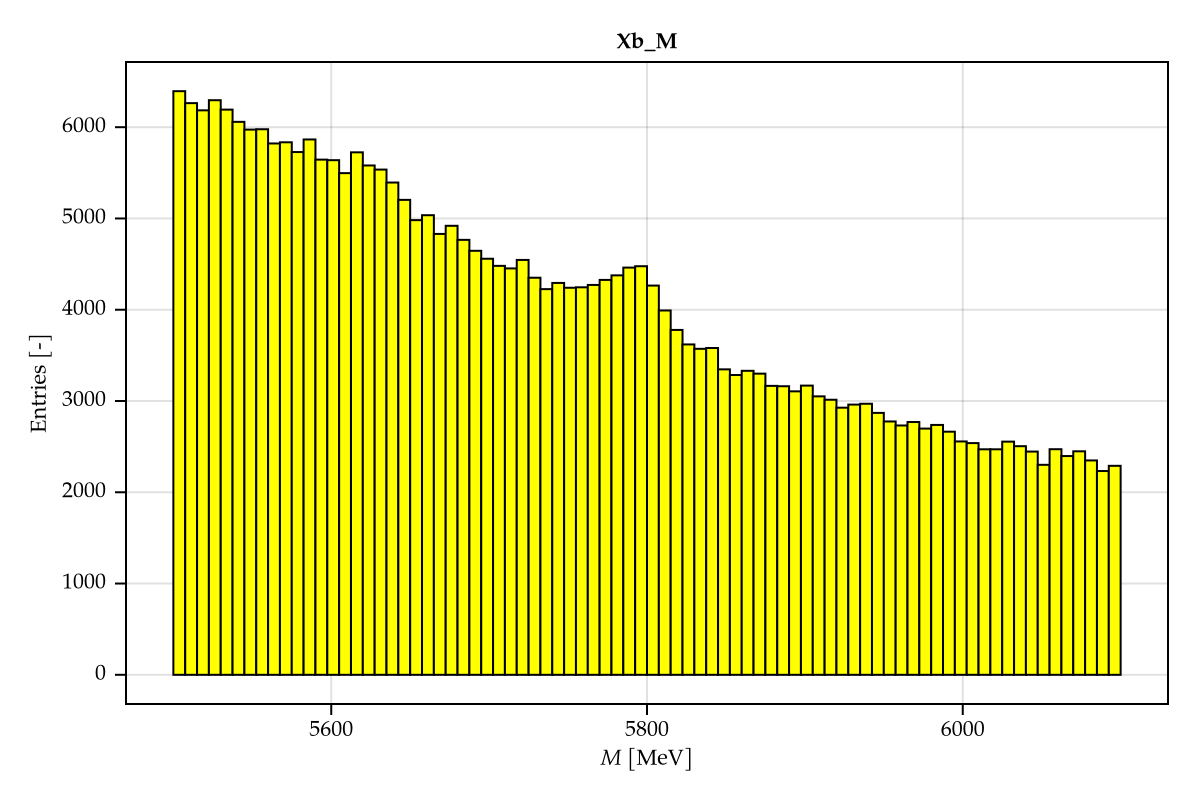

In [31]:
plot_hist(
    df_exp_cut.Xb_M,
    "figures/exp_Xb_M",
    title = "Xb_M",
    xlabel = L"$M$ [MeV]"
)

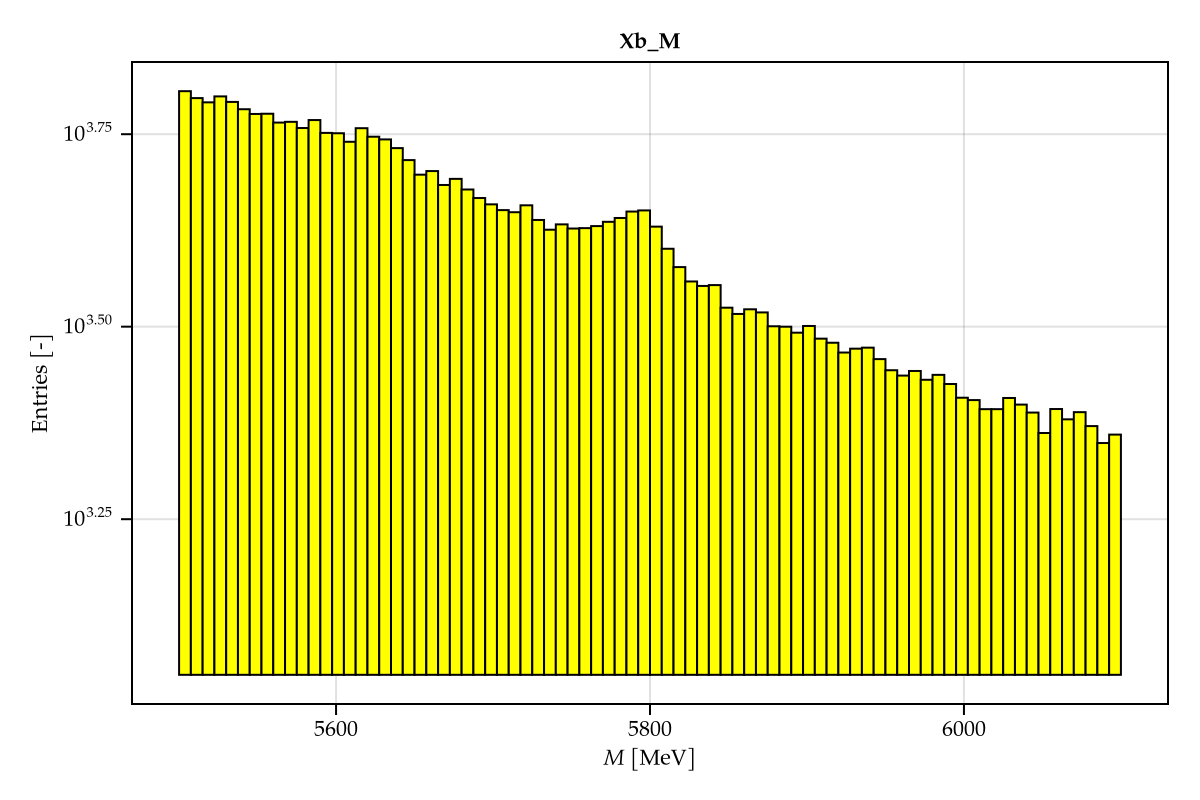

In [32]:
plot_hist(
    df_exp_cut.Xb_M,
    "figures/exp_Xb_M_log10",
    title = "Xb_M",
    xlabel = L"$M$ [MeV]",
    yscale = log10
)

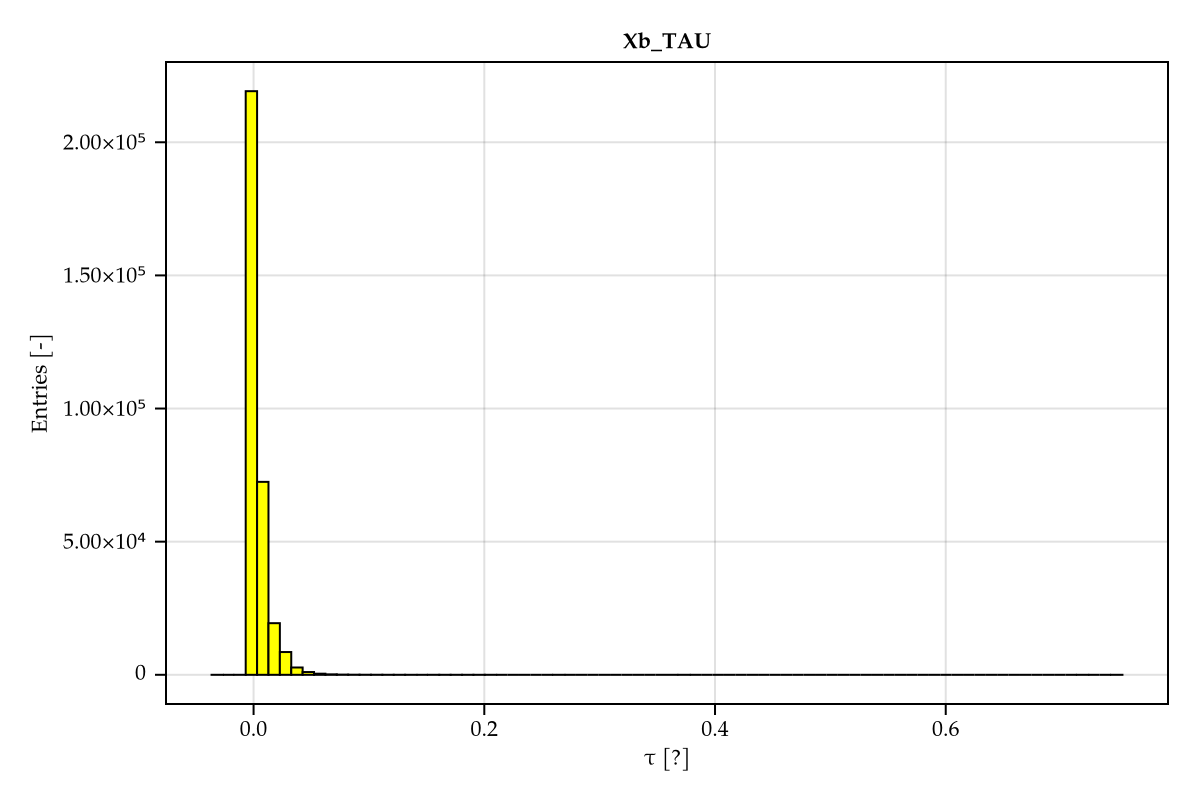

In [33]:
plot_hist(
    df_exp_cut.Xb_TAU,
    "figures/exp_Xb_TAU",
    title = "Xb_TAU",
    xlabel = L"$\tau$ [?]"
)

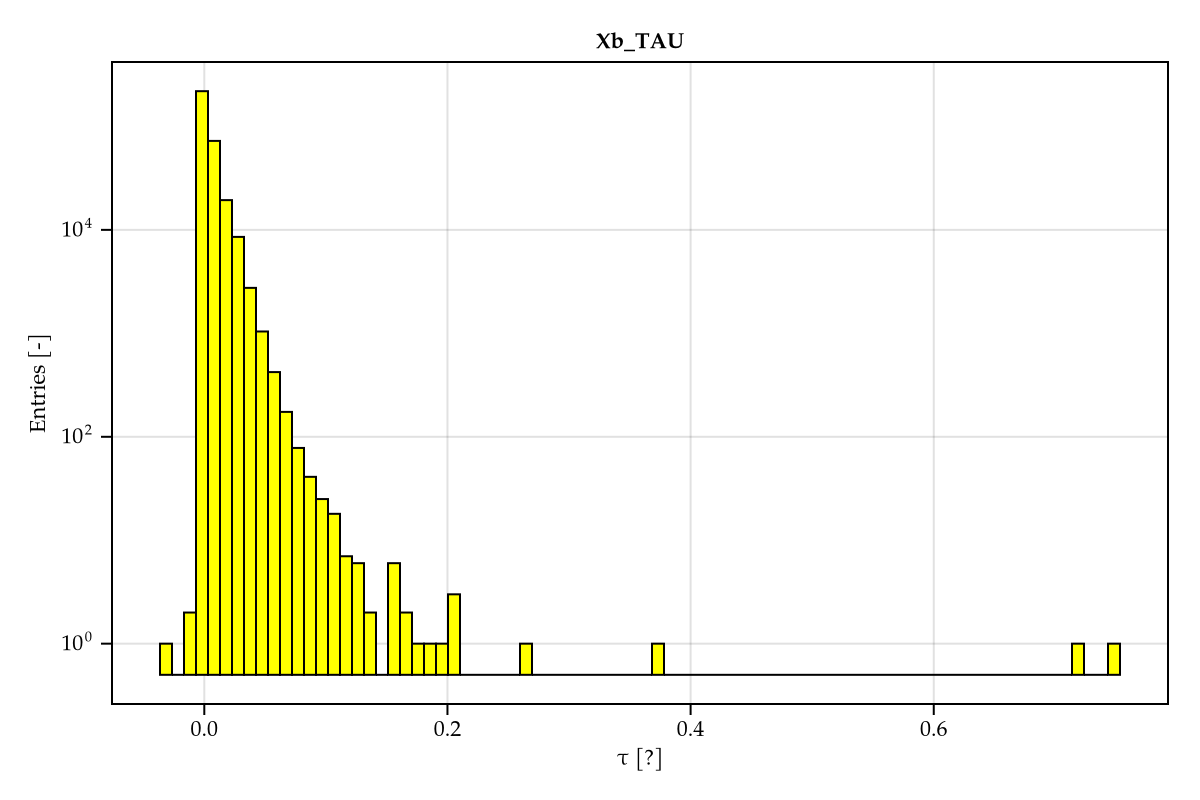

In [34]:
plot_hist(
    df_exp_cut.Xb_TAU,
    "figures/exp_Xb_TAU_log10",
    title = "Xb_TAU",
    xlabel = L"$τ$ [?]",
    yscale = log10
)

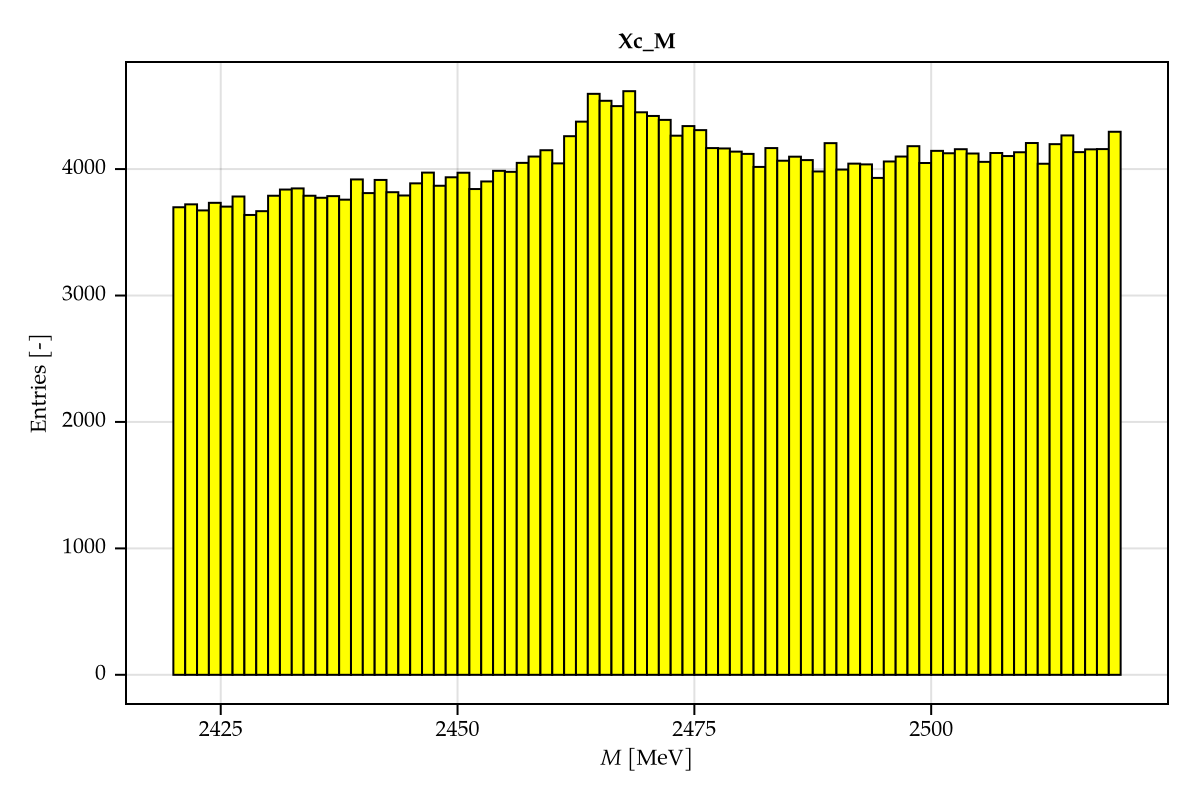

In [35]:
plot_hist(
    df_exp_cut.Xc_M,
    "figures/exp_Xc_M",
    title = "Xc_M",
    xlabel = L"$M$ [MeV]"
)

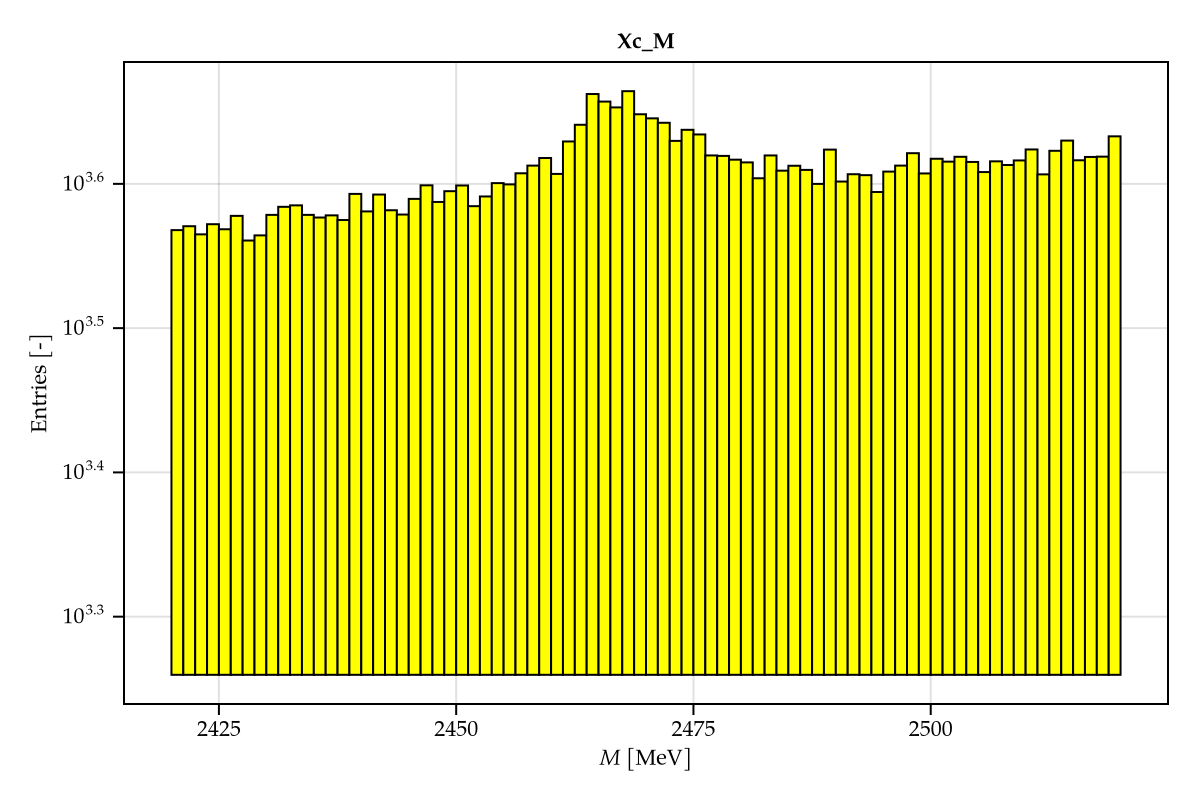

In [36]:
plot_hist(
    df_exp_cut.Xc_M,
    "figures/exp_Xc_M_log10",
    title = "Xc_M",
    xlabel = L"$M$ [MeV]",
    yscale = log10
)

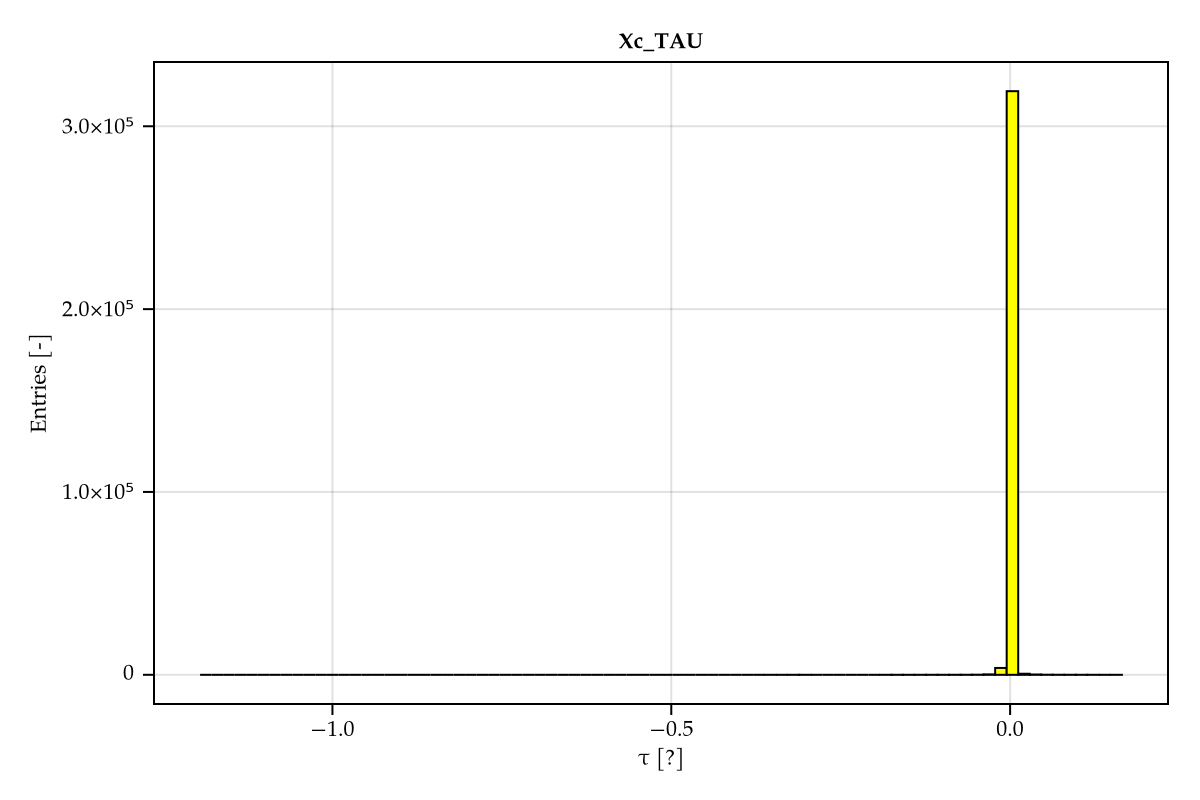

In [37]:
plot_hist(
    df_exp_cut.Xc_TAU,
    "figures/exp_Xc_TAU",
    title = "Xc_TAU",
    xlabel = L"$τ$ [?]"
)

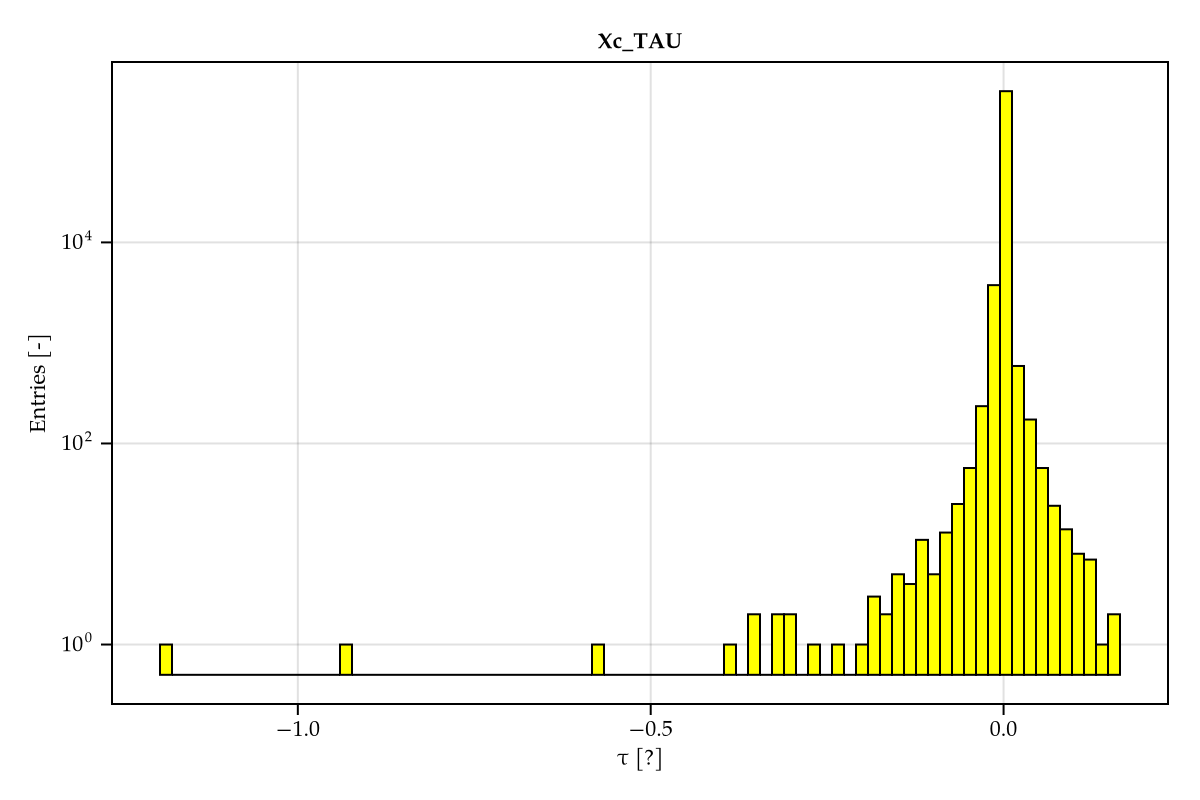

In [38]:
plot_hist(
    df_exp_cut.Xc_TAU,
    "figures/exp_Xc_TAU_log10",
    title = "Xc_TAU",
    xlabel = L"$τ$ [?]",
    yscale = log10
)

I guess we could force more restrictive cuts on Xc_TAU and on Xb_TAU, but the histograms above look _good enough_ in my opinion.

### simulation data

In [39]:
df_sim = LazyTree(f_sim, "mytree", vcat(["Xb_M", "Xc_M", "Xb_TAU", "Xc_TAU"], features)) |> DataFrame

Row,p_TRACK_CHI2NDOF,Xc_TAU,Xb_TAU,pi_PT,Xb_IPCHI2_OWNPV,p_TRACK_GhostProb,k_TRACK_CHI2NDOF,Xb_DIRA_OWNPV,pi_TRACK_CHI2NDOF,Xb_ENDVERTEX_CHI2,Xc_DIRA_OWNPV,pi_TRACK_GhostProb,Xb_M,Xc_IPCHI2_OWNPV,Xc_FDCHI2_OWNPV,k_PT,Xc_PT,k_ProbNNk,Xc_M,Xb_PT,p_ProbNNp,k_TRACK_GhostProb,Xb_FDCHI2_OWNPV,Xc_ENDVERTEX_CHI2,pi_ProbNNpi,p_PT
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.996301,0.000277802,0.00109034,346.519,0.433095,0.0154304,1.14639,0.999999,1.27208,1.20425,0.999848,0.00466894,5778.74,266.607,1081.54,1439.07,6917.23,0.998868,2455.75,8411.69,0.998234,0.00303757,500.184,5.44936,0.977561,5202.87
2,1.04395,0.00036955,0.000349707,795.09,1.40583,0.00223121,1.18313,0.999986,1.05847,0.225984,0.999995,0.0136601,5781.78,5.51045,200.653,2882.17,7905.67,0.996149,2468.15,8452.66,0.916844,0.00386014,311.296,1.45089,0.968933,4048.24
3,1.61425,0.00027449,0.00166607,350.318,0.330191,0.00820371,0.619714,1.0,1.11574,0.00407125,0.99963,0.0213888,5776.9,164.425,1311.95,1127.95,1723.23,0.996678,2469.67,8387.8,0.669752,0.00281761,472.732,0.307682,0.850347,310.8
4,0.51003,0.000175057,0.001581,508.481,3.23644,0.00279606,0.685326,0.999998,0.752516,0.837015,0.99974,0.00266205,5787.74,160.57,742.95,640.957,2286.67,0.931142,2465.3,8435.74,0.999576,0.00189818,1492.36,1.16142,0.997814,1232.24
5,1.61912,0.000399498,0.00302469,1011.69,4.89508,0.0261651,0.984081,0.999999,1.26237,5.84093,0.999925,0.00242101,5814.24,802.975,4745.21,1756.43,6982.3,0.208836,2462.82,8520.56,0.88848,0.00213955,9814.51,2.091,0.991011,3993.97
6,1.63484,0.000499724,0.0017883,792.654,3.08715,0.00947972,0.903913,0.999999,0.792349,8.08995,0.999718,0.00233148,5800.85,403.507,1174.79,552.715,2200.55,0.701843,2462.62,8520.48,0.655407,0.00389242,1554.64,6.16673,0.995103,984.309
7,1.13329,0.00071492,0.000629703,243.185,0.337043,0.00276318,0.79467,0.999999,0.969705,0.402802,0.999844,0.00329709,5776.49,55.567,487.053,256.787,3081.98,0.0407881,2461.86,8464.98,0.915604,0.0170103,116.251,4.08782,0.930563,2891.8
8,1.60016,1.01662e-5,0.00125697,1830.89,5.53854,0.0127467,0.802521,0.999996,0.61964,0.00189843,0.999575,0.0034978,5781.36,326.863,587.921,502.366,3608.14,0.29166,2460.7,8455.44,0.587953,0.0042771,1033.54,0.592678,0.988524,863.161
9,0.746302,0.000238951,0.000967629,618.769,0.819479,0.00254563,1.1924,0.999999,0.462343,0.2597,0.999609,0.00272088,5776.04,275.835,1024.23,671.643,3616.65,0.918388,2464.5,8426.84,0.948832,0.00373876,629.114,1.98296,0.99651,2476.25


#### plots

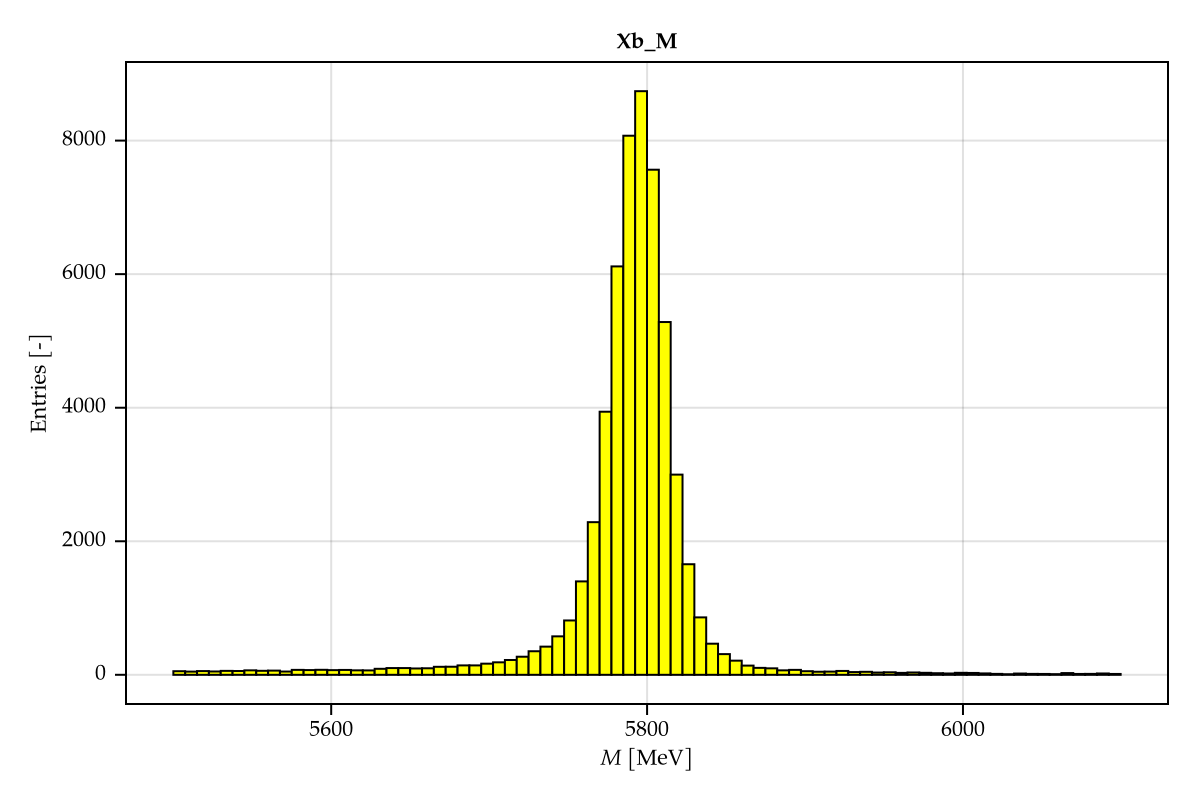

In [40]:
plot_hist(
    df_sim.Xb_M,
    "figures/sim_Xb_M",
    title = "Xb_M",
    xlabel = L"$M$ [MeV]"
)

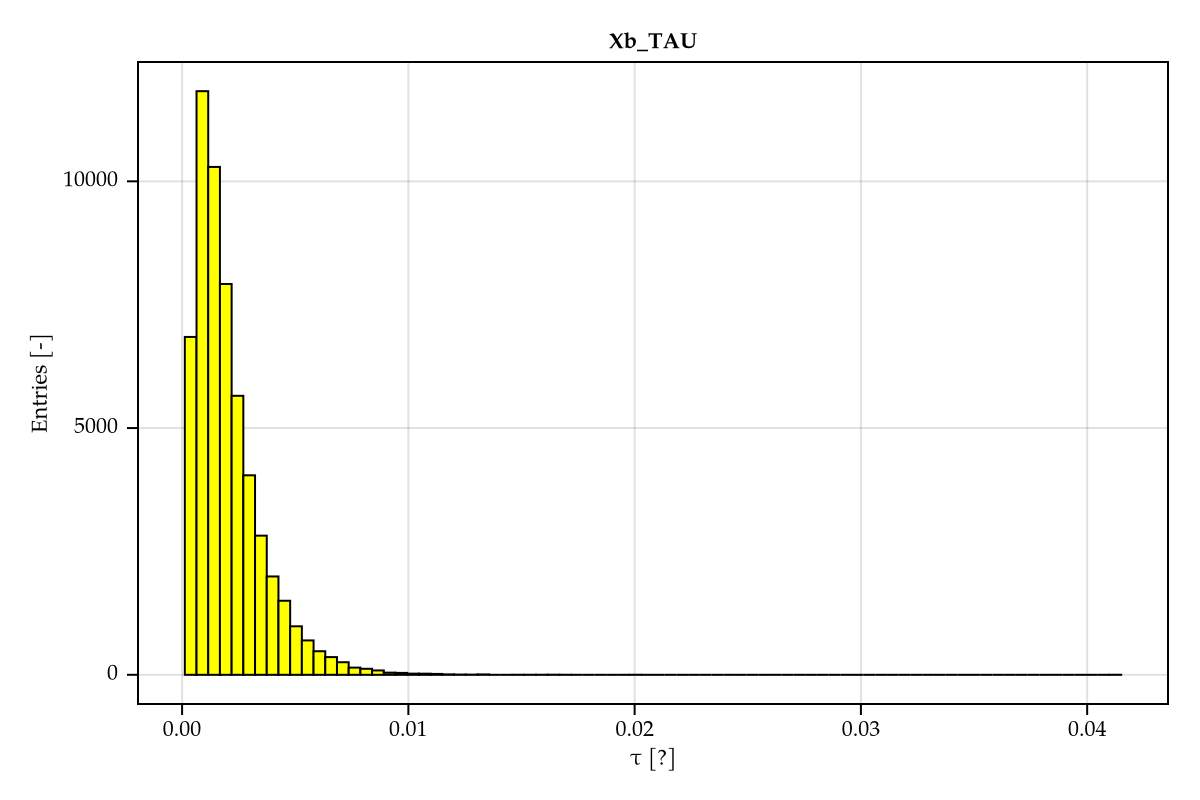

In [41]:
plot_hist(
    df_sim.Xb_TAU,
    "figures/sim_Xb_TAU",
    title = "Xb_TAU",
    xlabel = L"$\tau$ [?]"
)

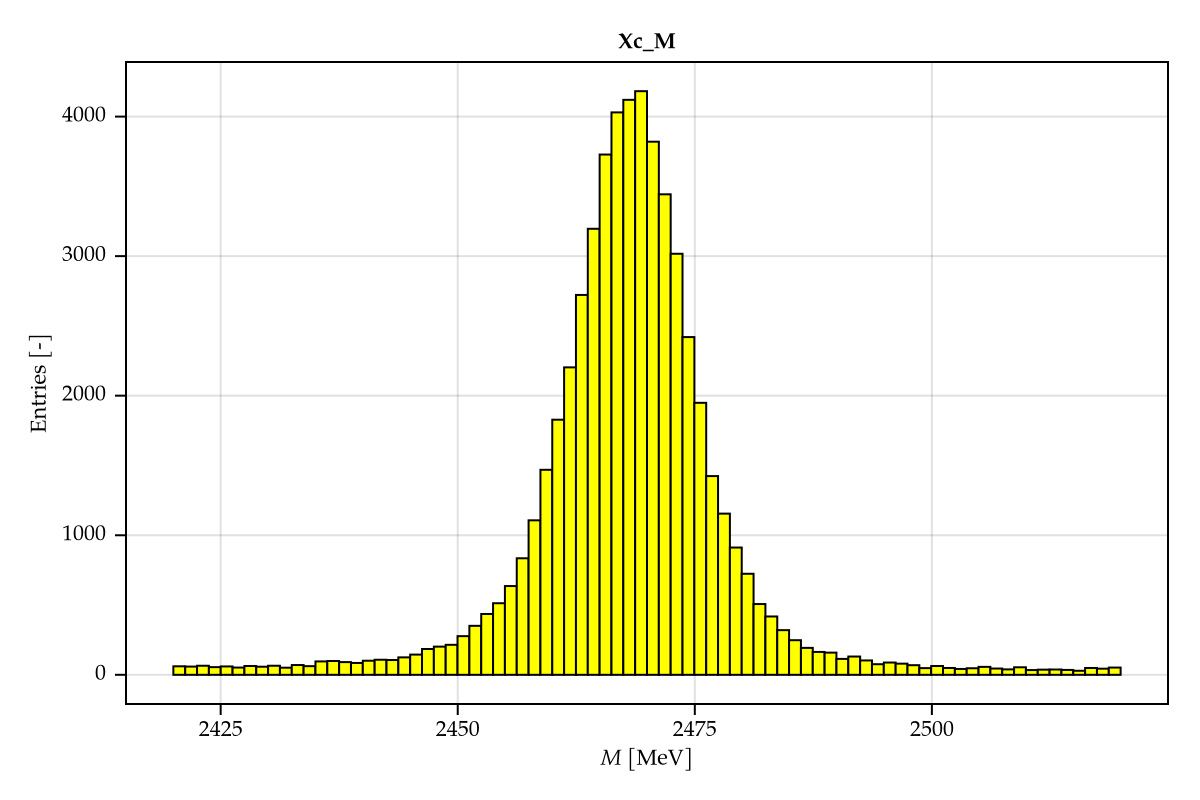

In [42]:
plot_hist(
    df_sim.Xc_M,
    "figures/sim_Xc_M",
    title = "Xc_M",
    xlabel = L"$M$ [MeV]"
)

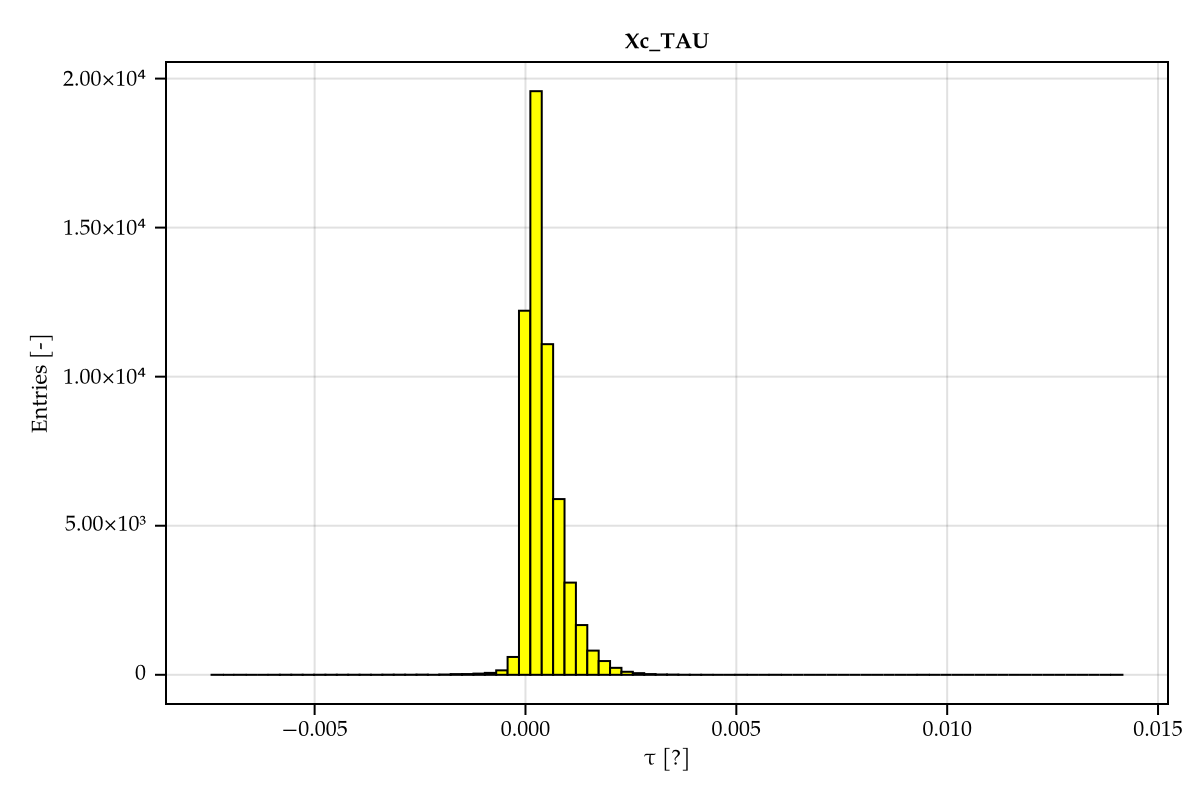

In [43]:
plot_hist(
    df_sim.Xc_TAU,
    "figures/sim_Xc_TAU",
    title = "Xc_TAU",
    xlabel = L"$\tau$ [?]"
)

I don't think doing lin-log plots is necessary here, the simulation data seem good enough.

## Signal/background data classifier (XGBoost decision tree)

#### prepare signal and background data

* Signal data: `df_sim`,
* Background data: subset of `df_exp`, where (as explained in the Introduction):
$$ M(\varXi_c^{\,+})<2450\,\text{MeV} \quad\vee\quad M(\varXi_c^{\,+})>2490\,\text{MeV} $$

In [44]:
df_signal = @select df_sim Not(:Xb_M, :Xb_TAU, :Xc_M, :Xc_TAU)
df_signal.label .= "signal"
df_signal;

In [45]:
df_background = @rsubset df_exp_cut :Xc_M < 2450 || :Xc_M > 2490
df_background = @select df_background Not(:Xb_M, :Xb_TAU, :Xc_M, :Xc_TAU)
df_background.label .= "background"
df_background;

In [46]:
df_sigbkg = vcat(df_signal, df_background)

Row,p_TRACK_CHI2NDOF,pi_PT,Xb_IPCHI2_OWNPV,p_TRACK_GhostProb,k_TRACK_CHI2NDOF,Xb_DIRA_OWNPV,pi_TRACK_CHI2NDOF,Xb_ENDVERTEX_CHI2,Xc_DIRA_OWNPV,pi_TRACK_GhostProb,Xc_IPCHI2_OWNPV,Xc_FDCHI2_OWNPV,k_PT,Xc_PT,k_ProbNNk,Xb_PT,p_ProbNNp,k_TRACK_GhostProb,Xb_FDCHI2_OWNPV,Xc_ENDVERTEX_CHI2,pi_ProbNNpi,p_PT,label
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,String
1,0.996301,346.519,0.433095,0.0154304,1.14639,0.999999,1.27208,1.20425,0.999848,0.00466894,266.607,1081.54,1439.07,6917.23,0.998868,8411.69,0.998234,0.00303757,500.184,5.44936,0.977561,5202.87,signal
2,1.04395,795.09,1.40583,0.00223121,1.18313,0.999986,1.05847,0.225984,0.999995,0.0136601,5.51045,200.653,2882.17,7905.67,0.996149,8452.66,0.916844,0.00386014,311.296,1.45089,0.968933,4048.24,signal
3,1.61425,350.318,0.330191,0.00820371,0.619714,1.0,1.11574,0.00407125,0.99963,0.0213888,164.425,1311.95,1127.95,1723.23,0.996678,8387.8,0.669752,0.00281761,472.732,0.307682,0.850347,310.8,signal
4,0.51003,508.481,3.23644,0.00279606,0.685326,0.999998,0.752516,0.837015,0.99974,0.00266205,160.57,742.95,640.957,2286.67,0.931142,8435.74,0.999576,0.00189818,1492.36,1.16142,0.997814,1232.24,signal
5,1.61912,1011.69,4.89508,0.0261651,0.984081,0.999999,1.26237,5.84093,0.999925,0.00242101,802.975,4745.21,1756.43,6982.3,0.208836,8520.56,0.88848,0.00213955,9814.51,2.091,0.991011,3993.97,signal
6,1.63484,792.654,3.08715,0.00947972,0.903913,0.999999,0.792349,8.08995,0.999718,0.00233148,403.507,1174.79,552.715,2200.55,0.701843,8520.48,0.655407,0.00389242,1554.64,6.16673,0.995103,984.309,signal
7,1.13329,243.185,0.337043,0.00276318,0.79467,0.999999,0.969705,0.402802,0.999844,0.00329709,55.567,487.053,256.787,3081.98,0.0407881,8464.98,0.915604,0.0170103,116.251,4.08782,0.930563,2891.8,signal
8,1.60016,1830.89,5.53854,0.0127467,0.802521,0.999996,0.61964,0.00189843,0.999575,0.0034978,326.863,587.921,502.366,3608.14,0.29166,8455.44,0.587953,0.0042771,1033.54,0.592678,0.988524,863.161,signal
9,0.746302,618.769,0.819479,0.00254563,1.1924,0.999999,0.462343,0.2597,0.999609,0.00272088,275.835,1024.23,671.643,3616.65,0.918388,8426.84,0.948832,0.00373876,629.114,1.98296,0.99651,2476.25,signal


#### split into training and test data

In [47]:
X = df_sigbkg[:, features]  # features
y = df_sigbkg.label |> categorical  # targets

train, test = partition(eachindex(y), 0.7, shuffle=true, rng=8054)  # train and test indices

([29669, 116192, 225968, 5860, 77990, 98911, 59490, 239392, 180912, 138435  …  100270, 181956, 190036, 88700, 134014, 213016, 169934, 177026, 166903, 17041], [38156, 124819, 111940, 159479, 144610, 180810, 9562, 38816, 223688, 8103  …  232482, 226220, 206152, 35536, 198530, 96693, 38755, 173550, 158579, 175643])

In [48]:
levels(y)

2-element CategoricalArrays.CategoricalArray{String,1,UInt32}:
 "background"
 "signal"

### prepare model

In [49]:
XGBC = @load XGBoostClassifier

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/yantah/.julia/packages/MLJModels/BfLy4/src/loading.jl:159


import MLJXGBoostInterface ✔


MLJXGBoostInterface.XGBoostClassifier

In [50]:
model = XGBC(
    num_round = 400,
    max_depth = 6,
    eta = 0.1,
    subsample = 0.8,
    colsample_bytree = 0.8,
    gamma = 0.2,
    seed = 8054,
)

XGBoostClassifier(
  test = 1, 
  num_round = 400, 
  booster = "gbtree", 
  disable_default_eval_metric = 0, 
  eta = 0.1, 
  num_parallel_tree = 1, 
  gamma = 0.2, 
  max_depth = 6, 
  min_child_weight = 1.0, 
  max_delta_step = 0.0, 
  subsample = 0.8, 
  colsample_bytree = 0.8, 
  colsample_bylevel = 1.0, 
  colsample_bynode = 1.0, 
  lambda = 1.0, 
  alpha = 0.0, 
  tree_method = "auto", 
  sketch_eps = 0.03, 
  scale_pos_weight = 1.0, 
  updater = nothing, 
  refresh_leaf = 1, 
  process_type = "default", 
  grow_policy = "depthwise", 
  max_leaves = 0, 
  max_bin = 256, 
  predictor = "cpu_predictor", 
  sample_type = "uniform", 
  normalize_type = "tree", 
  rate_drop = 0.0, 
  one_drop = 0, 
  skip_drop = 0.0, 
  feature_selector = "cyclic", 
  top_k = 0, 
  tweedie_variance_power = 1.5, 
  objective = "automatic", 
  base_score = 0.5, 
  early_stopping_rounds = 0, 
  watchlist = nothing, 
  nthread = 1, 
  importance_type = "gain", 
  seed = 8054, 
  validate_parameters = fal

### fit the model to training data

In [51]:
mach = machine(model, X, y)
fit!(mach, rows=train)

┌ Info: Training machine(XGBoostClassifier(test = 1, …), …).
└ @ MLJBase /home/yantah/.julia/packages/MLJBase/yVJvJ/src/machines.jl:499
┌ Info: XGBoost: starting training.
└ @ XGBoost /home/yantah/.julia/packages/XGBoost/5SES5/src/booster.jl:601
┌ Info: [1]	train-logloss:0.62759867549680137
└ @ XGBoost /home/yantah/.julia/packages/XGBoost/5SES5/src/booster.jl:451
┌ Info: [2]	train-logloss:0.56907250272811993
└ @ XGBoost /home/yantah/.julia/packages/XGBoost/5SES5/src/booster.jl:451
┌ Info: [3]	train-logloss:0.51994625412145135
└ @ XGBoost /home/yantah/.julia/packages/XGBoost/5SES5/src/booster.jl:451
┌ Info: [4]	train-logloss:0.48547166775244099
└ @ XGBoost /home/yantah/.julia/packages/XGBoost/5SES5/src/booster.jl:451
┌ Info: [5]	train-logloss:0.44878084597170259
└ @ XGBoost /home/yantah/.julia/packages/XGBoost/5SES5/src/booster.jl:451
┌ Info: [6]	train-logloss:0.42466101822125096
└ @ XGBoost /home/yantah/.julia/packages/XGBoost/5SES5/src/booster.jl:451
┌ Info: [7]	train-logloss:0.399405

trained Machine; caches model-specific representations of data
  model: XGBoostClassifier(test = 1, …)
  args: 
    1:	Source @547 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @744 ⏎ AbstractVector{Multiclass{2}}


### predict on test data (and test the model)

In [52]:
ŷ_test_prob = predict(mach, rows=test)

73840-element CategoricalDistributions.UnivariateFiniteVector{Multiclass{2}, String, UInt32, Float32}:
 UnivariateFinite{Multiclass{2}}(background=>0.121, signal=>0.879)
 UnivariateFinite{Multiclass{2}}(background=>1.0, signal=>0.000204)
 UnivariateFinite{Multiclass{2}}(background=>1.0, signal=>0.00011)
 UnivariateFinite{Multiclass{2}}(background=>1.0, signal=>1.88e-5)
 UnivariateFinite{Multiclass{2}}(background=>1.0, signal=>0.000148)
 UnivariateFinite{Multiclass{2}}(background=>1.0, signal=>0.000156)
 UnivariateFinite{Multiclass{2}}(background=>0.0196, signal=>0.98)
 UnivariateFinite{Multiclass{2}}(background=>0.021, signal=>0.979)
 UnivariateFinite{Multiclass{2}}(background=>0.353, signal=>0.647)
 UnivariateFinite{Multiclass{2}}(background=>0.0122, signal=>0.988)
 ⋮
 UnivariateFinite{Multiclass{2}}(background=>0.999, signal=>0.000648)
 UnivariateFinite{Multiclass{2}}(background=>0.999, signal=>0.00071)
 UnivariateFinite{Multiclass{2}}(background=>0.967, signal=>0.0331)
 UnivariateFi

In [53]:
# ŷ_test = predict_mode(mach, rows=test)  # not optimal, assumes 0.5 threshold.

ŷ_test_sigprob = pdf.(ŷ_test_prob, "signal")

threshold = .9

ŷ_test = ifelse.(ŷ_test_sigprob .> threshold, "signal", "background") |> categorical

73840-element CategoricalArrays.CategoricalArray{String,1,UInt32}:
 "background"
 "background"
 "background"
 "background"
 "background"
 "background"
 "signal"
 "signal"
 "background"
 "signal"
 ⋮
 "background"
 "background"
 "background"
 "background"
 "background"
 "signal"
 "background"
 "background"
 "background"

#### ROC curve

In [54]:
roc = roc_curve(ŷ_test_prob, y[test]);

┌ Warning: Levels not explicitly ordered. Using the order ["background", "signal"]. The "positive" level is signal. 
└ @ StatisticalMeasures /home/yantah/.julia/packages/StatisticalMeasures/RRiuf/src/roc.jl:28


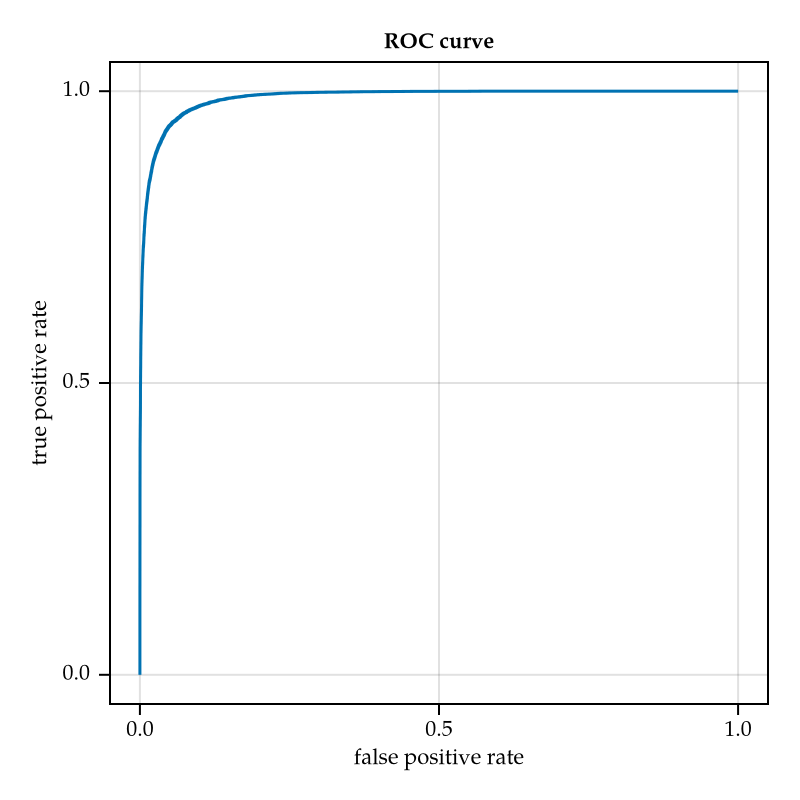

In [55]:
fig_roc = Figure(; size=(400,400))

ax = Axis(
    fig_roc[1, 1],
    title = "ROC curve",
    xlabel = "false positive rate",
    ylabel = "true positive rate",
)

lines!(
    roc[1],
    roc[2],
)

fig_roc

#### confusion matrix

In [56]:
cm = confusion_matrix(y[test], ŷ_test)

           ┌─────────────────────┐
           │    Ground Truth     │
┌──────────┼──────────┬──────────┤
│Predicted │backgrou… │  signal  │
├──────────┼──────────┼──────────┤
│backgrou… │  56901   │   208    │
├──────────┼──────────┼──────────┤
│  signal  │   5369   │  11362   │
└──────────┴──────────┴──────────┘


## Apply model to experiment data

In [57]:
# take out feature columns from the experiment dataset
X_exp = df_exp_cut[:, features]

# predict probabilities (signal/background)
ŷ_exp_prob = predict(mach, X_exp)

# signal probabilities (boosted decision tree response)
ŷ_exp_sigprob = pdf.(ŷ_exp_prob, "signal")
df_exp_cut.BDT_response = ŷ_exp_sigprob

# apply threshold to the BDT response
df_exp_cut.isSignal = ŷ_exp_sigprob .> threshold  # using same threshold as in model testing

df_exp_cut

Row,p_TRACK_CHI2NDOF,Xc_TAU,Xb_TAU,pi_PT,Xb_IPCHI2_OWNPV,p_TRACK_GhostProb,k_TRACK_CHI2NDOF,Xb_DIRA_OWNPV,pi_TRACK_CHI2NDOF,Xb_ENDVERTEX_CHI2,Xc_DIRA_OWNPV,pi_TRACK_GhostProb,Xb_M,Xc_IPCHI2_OWNPV,Xc_FDCHI2_OWNPV,k_PT,Xc_PT,k_ProbNNk,Xc_M,Xb_PT,p_ProbNNp,k_TRACK_GhostProb,Xb_FDCHI2_OWNPV,Xc_ENDVERTEX_CHI2,pi_ProbNNpi,p_PT,BDT_response,isSignal
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float32,Bool
1,0.916201,0.000815827,0.00167324,128.175,50.0878,0.00951012,0.893705,0.999913,2.11694,0.047918,0.999984,0.313751,5906.68,127.808,1511.59,3332.74,7477.31,0.228634,2510.3,6894.96,0.216751,0.0033191,507.372,1.76876,0.0543855,4053.7,9.43449e-5,false
2,0.673245,0.00138945,0.0026473,4475.73,5.41138,0.00294041,0.759904,0.999998,1.93229,0.274207,0.999545,0.0447053,5679.12,1802.61,8142.38,1438.16,8059.38,0.935612,2468.57,12263.8,0.366651,0.00341138,11738.4,14.9461,0.790995,1640.81,0.00611076,false
3,1.51315,-0.000351875,0.000806715,678.489,20.0116,0.00531317,0.935301,0.999964,1.13082,3.81626,0.994573,0.00415959,5690.74,58.1446,65.4925,1797.68,2690.1,0.997921,2517.45,9822.61,0.37178,0.00375488,419.79,1.69332,0.997966,443.215,0.00489305,false
4,1.23012,0.000624979,0.000491548,262.852,11.8004,0.0025048,1.08445,0.999913,2.07114,4.76857,0.999988,0.158746,5945.17,29.8475,413.465,3894.14,6788.47,0.460054,2428.47,6867.44,0.200149,0.00232569,51.807,1.48557,0.21611,2739.07,0.00267617,false
5,0.844429,0.00113982,0.00240525,161.211,11.8522,0.0180421,0.981377,0.999989,0.997703,2.68415,0.999291,0.0246846,5646.24,350.99,415.566,1302.94,1823.01,0.924755,2484.98,7531.45,0.719652,0.00451679,2576.45,1.35653,0.954604,408.723,0.0469138,false
6,1.76191,1.11562e-6,0.00129938,772.127,8.52095,0.00456974,0.668473,0.999991,0.768105,2.82344,0.999355,0.00536665,5561.59,98.7232,446.497,463.949,1606.59,0.948623,2444.5,5357.65,0.899079,0.00441898,261.553,0.141041,0.984076,643.541,0.0154317,false
7,1.59362,0.000933746,0.00228823,1255.15,86.5175,0.318535,1.35356,0.999951,0.697048,2.53569,0.999646,0.00300516,5596.13,394.034,1343.27,368.392,2291.52,0.144492,2439.99,2990.9,0.388912,0.00539023,1459.21,17.6746,0.969696,778.657,0.000618652,false
8,1.13069,0.00241897,0.00160916,661.248,15.7621,0.00430404,0.499573,0.999963,1.48535,0.689831,0.999935,0.0297656,6031.52,88.2765,374.476,1097.2,2138.7,0.239343,2491.02,2743.43,0.880779,0.0028453,1012.79,3.18664,0.990926,478.557,0.0297787,false
9,1.57668,-2.46276e-5,0.00108872,1165.43,1.95124,0.0228336,1.08719,0.999978,0.698005,5.11059,0.99668,0.0036398,5647.72,160.145,500.712,3416.34,7946.66,0.998203,2462.74,11692.0,0.42274,0.00352195,777.882,1.6963,0.997828,3298.79,0.283138,false


#### Plot out stacked mass histograms

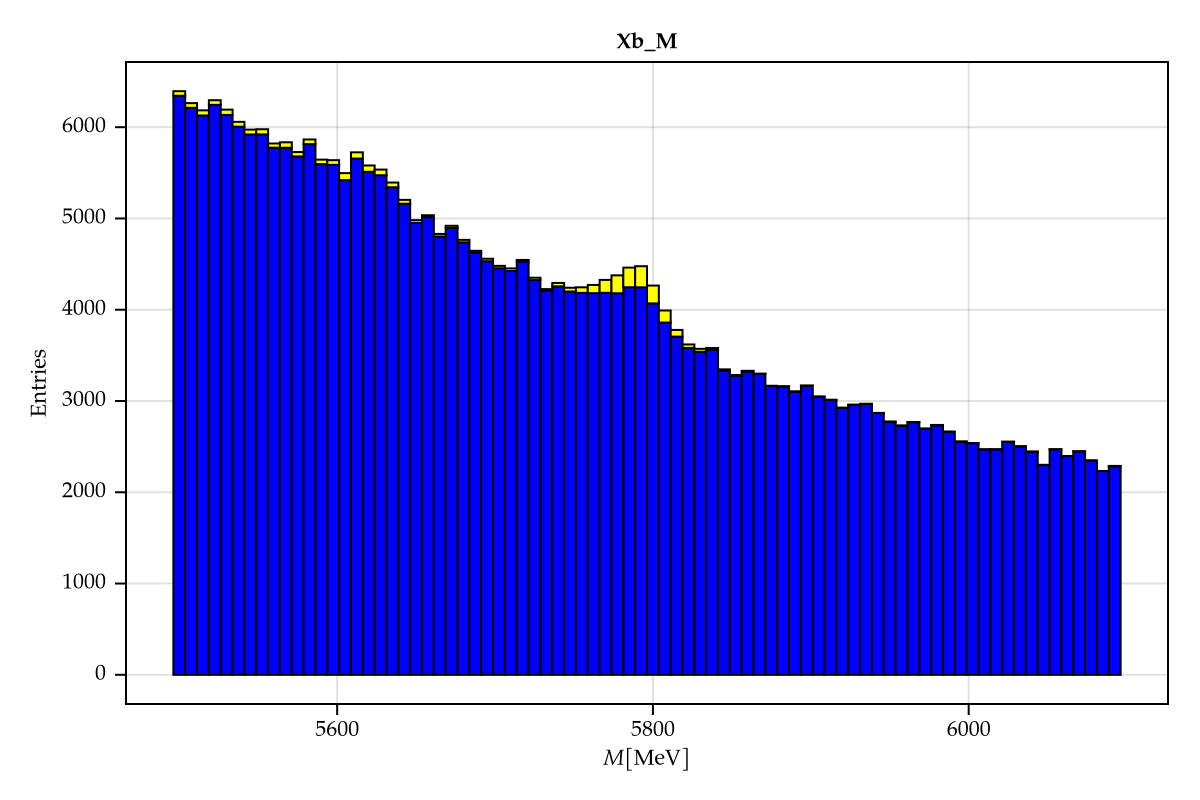

In [58]:

fig_Xb_M_final = Figure(; size=(600,400))

bins = range(minimum(df_exp_cut.Xb_M), maximum(df_exp_cut.Xb_M), 81)

hist_background = StatsBase.fit(StatsBase.Histogram, @rsubset(df_exp_cut, !:isSignal).Xb_M, bins)
hist_signal = StatsBase.fit(StatsBase.Histogram, @rsubset(df_exp_cut, :isSignal).Xb_M, bins)

ax = Axis(
    fig_Xb_M_final[1, 1],
    title = "Xb_M",
    xlabel = L"M [\text{MeV}]",
    ylabel = "Entries",
)

barplot!(
    hist_background.edges[1][1:end-1],
    hist_background.weights,
    width = step(bins),
    gap = 0,
    color = :blue,
    strokecolor = :black,
    strokewidth = 1,
    label = "background"
)

barplot!(
    hist_background.edges[1][1:end-1],
    hist_signal.weights,
    width = step(bins),
    gap = 0,
    color = :yellow,
    strokecolor = :black,
    strokewidth = 1,
    offset = hist_background.weights,
    label = "signal"
)

save("figures/exp_Xb_M_final.pdf", fig_Xb_M_final)

fig_Xb_M_final

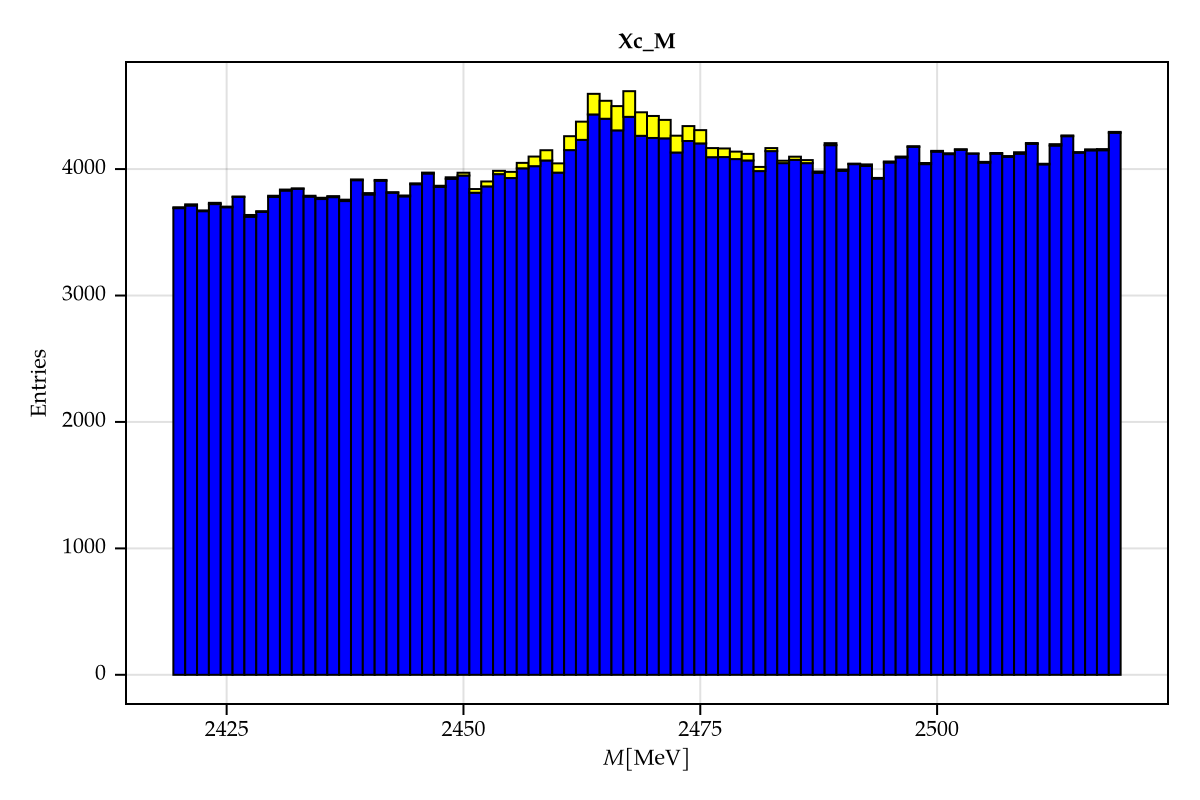

In [59]:

fig_Xc_M_final = Figure(; size=(600,400))

bins = range(minimum(df_exp_cut.Xc_M), maximum(df_exp_cut.Xc_M), 81)

hist_background = StatsBase.fit(StatsBase.Histogram, @rsubset(df_exp_cut, !:isSignal).Xc_M, bins)
hist_signal = StatsBase.fit(StatsBase.Histogram, @rsubset(df_exp_cut, :isSignal).Xc_M, bins)

ax = Axis(
    fig_Xc_M_final[1, 1],
    title = "Xc_M",
    xlabel = L"M [\text{MeV}]",
    ylabel = "Entries",
)

barplot!(
    hist_background.edges[1][1:end-1],
    hist_background.weights,
    width = step(bins),
    gap = 0,
    color = :blue,
    strokecolor = :black,
    strokewidth = 1,
    label = "background"
)

barplot!(
    hist_background.edges[1][1:end-1],
    hist_signal.weights,
    width = step(bins),
    gap = 0,
    color = :yellow,
    strokecolor = :black,
    strokewidth = 1,
    offset = hist_background.weights,
    label = "signal"
)

save("figures/exp_Xc_M_final.pdf", fig_Xc_M_final)

fig_Xc_M_final